In [43]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

#from bs4 import BeautifulSoup
import os

!pip install folium
import folium # map rendering library

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

!pip install seaborn
import seaborn as sns

print('Libraries imported.')

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Libraries imported.


#### Define credentials

In [44]:
CLIENT_ID = 'E2JJU0UHUMQ5V4A34ANQL3MLFRHSWRFPBPYBFD2VNTG2EO5J' # your Foursquare ID
CLIENT_SECRET = 'IQH1H1QHBMYB0ID5KEUB2BZU2522Y1YTBI0EMWFCQCODI0WO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [45]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [91]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


#### Data Analysis

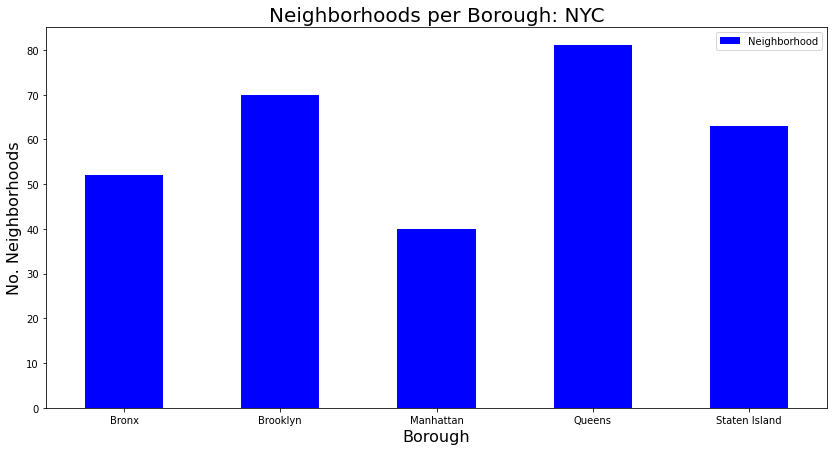

In [47]:
clr = "blue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(14,7), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 16)
plt.ylabel('No. Neighborhoods',fontsize = 16)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [48]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_restaurants=venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(ny_data),')','Chinese Restaurant in '+Neighborhood+', '+Borough+':'+str(len(chinese_restaurants)))
    print(row)
    for resturant_detail in chinese_restaurants.values.tolist():
        id, name , category=resturant_detail
        chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Chinese Restaurant in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Chinese Restaurant in Co-op City, Bronx:1
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Chinese Restaurant in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Chinese Restaurant in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Chinese Restaurant in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Chinese Restaurant in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Chinese Restaurant in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Chinese Restaurant in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Chinese Restaurant in Norwood, Bronx:1
['Bronx', '

( 68 / 306 ) Chinese Restaurant in Red Hook, Brooklyn:0
['Brooklyn', 'Red Hook', 40.676253230250886, -74.0127589747356]
( 69 / 306 ) Chinese Restaurant in Gowanus, Brooklyn:1
['Brooklyn', 'Gowanus', 40.673931143187154, -73.99444087145339]
( 70 / 306 ) Chinese Restaurant in Fort Greene, Brooklyn:0
['Brooklyn', 'Fort Greene', 40.68852726018977, -73.97290574369092]
( 71 / 306 ) Chinese Restaurant in Park Slope, Brooklyn:2
['Brooklyn', 'Park Slope', 40.67232052268197, -73.97705030183924]
( 72 / 306 ) Chinese Restaurant in Cypress Hills, Brooklyn:1
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 73 / 306 ) Chinese Restaurant in East New York, Brooklyn:2
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 74 / 306 ) Chinese Restaurant in Starrett City, Brooklyn:1
['Brooklyn', 'Starrett City', 40.64758905230874, -73.87936970045875]
( 75 / 306 ) Chinese Restaurant in Canarsie, Brooklyn:0
['Brooklyn', 'Canarsie', 40.63556432797428, -73.90209269778966]


( 132 / 306 ) Chinese Restaurant in Jackson Heights, Queens:0
['Queens', 'Jackson Heights', 40.75198138007367, -73.88282109164365]
( 133 / 306 ) Chinese Restaurant in Elmhurst, Queens:2
['Queens', 'Elmhurst', 40.744048505122024, -73.88165622288388]
( 134 / 306 ) Chinese Restaurant in Howard Beach, Queens:1
['Queens', 'Howard Beach', 40.65422527738487, -73.8381376460028]
( 135 / 306 ) Chinese Restaurant in Corona, Queens:1
['Queens', 'Corona', 40.74238175015667, -73.85682497345258]
( 136 / 306 ) Chinese Restaurant in Forest Hills, Queens:1
['Queens', 'Forest Hills', 40.72526378216503, -73.84447500788983]
( 137 / 306 ) Chinese Restaurant in Kew Gardens, Queens:2
['Queens', 'Kew Gardens', 40.7051790354148, -73.82981905825703]
( 138 / 306 ) Chinese Restaurant in Richmond Hill, Queens:0
['Queens', 'Richmond Hill', 40.69794731471763, -73.83183321446887]
( 139 / 306 ) Chinese Restaurant in Flushing, Queens:2
['Queens', 'Flushing', 40.76445419697846, -73.83177300329582]
( 140 / 306 ) Chinese R

( 199 / 306 ) Chinese Restaurant in New Brighton, Staten Island:0
['Staten Island', 'New Brighton', 40.64061455913511, -74.08701650516625]
( 200 / 306 ) Chinese Restaurant in Stapleton, Staten Island:1
['Staten Island', 'Stapleton', 40.62692762538176, -74.07790192660066]
( 201 / 306 ) Chinese Restaurant in Rosebank, Staten Island:1
['Staten Island', 'Rosebank', 40.61530494652761, -74.06980526716141]
( 202 / 306 ) Chinese Restaurant in West Brighton, Staten Island:0
['Staten Island', 'West Brighton', 40.63187892654607, -74.1071817826561]
( 203 / 306 ) Chinese Restaurant in Grymes Hill, Staten Island:0
['Staten Island', 'Grymes Hill', 40.624184791313006, -74.08724819983729]
( 204 / 306 ) Chinese Restaurant in Todt Hill, Staten Island:0
['Staten Island', 'Todt Hill', 40.59706851814673, -74.1113288180088]
( 205 / 306 ) Chinese Restaurant in South Beach, Staten Island:0
['Staten Island', 'South Beach', 40.58024741350956, -74.0795529253982]
( 206 / 306 ) Chinese Restaurant in Port Richmond, 

( 260 / 306 ) Chinese Restaurant in Remsen Village, Brooklyn:0
['Brooklyn', 'Remsen Village', 40.652117451793494, -73.91665331978048]
( 261 / 306 ) Chinese Restaurant in New Lots, Brooklyn:2
['Brooklyn', 'New Lots', 40.6627442796966, -73.88511776379292]
( 262 / 306 ) Chinese Restaurant in Paerdegat Basin, Brooklyn:0
['Brooklyn', 'Paerdegat Basin', 40.63131755039667, -73.90233474295836]
( 263 / 306 ) Chinese Restaurant in Mill Basin, Brooklyn:2
['Brooklyn', 'Mill Basin', 40.61597423962336, -73.91515391550404]
( 264 / 306 ) Chinese Restaurant in Jamaica Hills, Queens:1
['Queens', 'Jamaica Hills', 40.71145964370482, -73.79646462081593]
( 265 / 306 ) Chinese Restaurant in Utopia, Queens:0
['Queens', 'Utopia', 40.73350025429757, -73.79671678028349]
( 266 / 306 ) Chinese Restaurant in Pomonok, Queens:0
['Queens', 'Pomonok', 40.73493618075478, -73.80486120040537]
( 267 / 306 ) Chinese Restaurant in Astoria Heights, Queens:0
['Queens', 'Astoria Heights', 40.7703173929982, -73.89467996270574]
(

In [49]:
chinese_rest_ny.to_csv('chinese_rest_ny_.csv')


In [50]:
chinese_ny = pd.read_csv('chinese_rest_ny_.csv')
chinese_rest_ny.tail()

,Borough,Neighborhood,ID,Name
176,Staten Island,Prince's Bay,4bb7d282b35776b0b83dc801,Island Taste
177,Bronx,Allerton,4c7dbf7f10916dcba78e2a96,Chef King
178,Bronx,Kingsbridge Heights,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant
179,Bronx,Kingsbridge Heights,4e4d03acbd413c4cc66dfed6,New No. 1 Chinese Restaurnt
180,Brooklyn,Erasmus,4e10c87122713f7d7bcb9d1d,Kam Man Chinese Food


#### How many chinese restaurants do we have in New York?

In [51]:
chinese_rest_ny.shape

(181, 4)

#### Brooklyn has the most Chinese restaurants. The Staten Island the least.

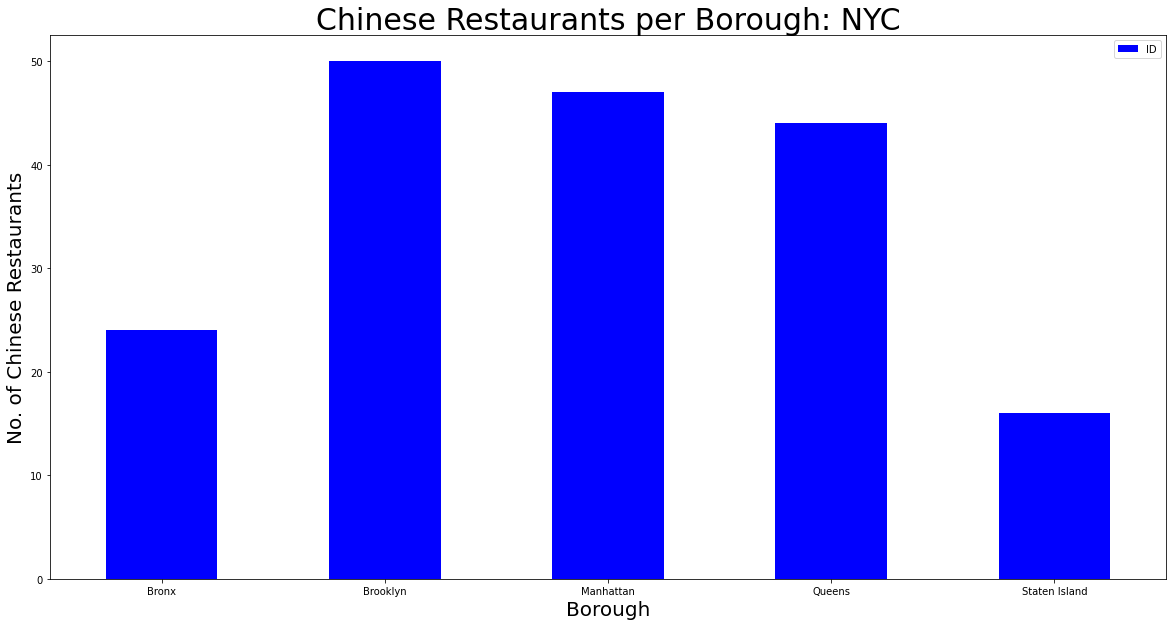

In [52]:
chinese_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(20,10), color=clr)
plt.title('Chinese Restaurants per Borough: NYC', fontsize = 30)
plt.xlabel('Borough', fontsize = 20)
plt.ylabel('No. of Chinese Restaurants', fontsize=20)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

### No wonder most of the restaurants are located in Chinatown, but the third one is Little Italy that is suprising by the way.

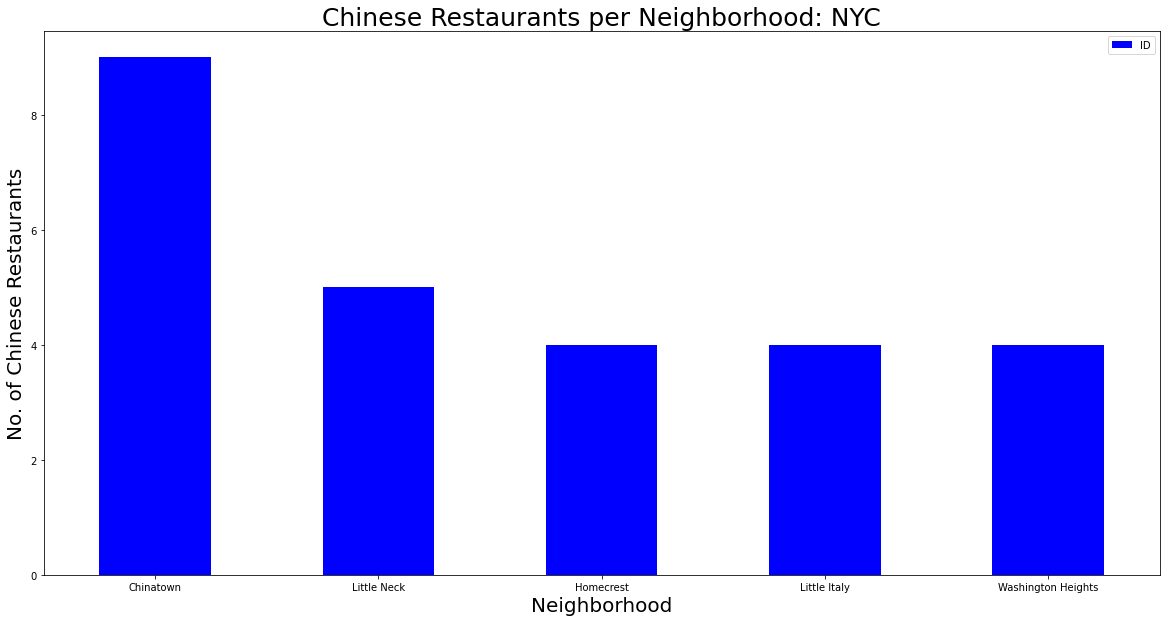

In [53]:
noOfNeigh = 5 
chinese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(noOfNeigh).plot.bar(figsize=(20,10), color=clr)
plt.title('Chinese Restaurants per Neighborhood: NYC', fontsize = 25)
plt.xlabel('Neighborhood', fontsize = 20)
plt.ylabel('No. of Chinese Restaurants', fontsize=20)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

### For further analysis we need get the material about restaurants, specifically rating. 

In [54]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats=pd.DataFrame(columns=column_names)
count=1
for row in chinese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # 0 value for resturants that recently opened or no details exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(chinese_rest_ny),')','processed')
    chinese_rest_stats= chinese_rest_stats.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
chinese_rest_stats.tail()

{'meta': {'code': 200, 'requestId': '5f33ad8bcf2d854abdbbaae9'}, 'response': {'venue': {'id': '4c9d5f2654c8a1cd2e71834b', 'name': 'Guang Hui Chinese Restaurant', 'contact': {'phone': '7188623288', 'formattedPhone': '(718) 862-3288'}, 'location': {'address': '125 Dreiser Loop', 'lat': 40.876651, 'lng': -73.829092, 'labeledLatLngs': [{'label': 'display', 'lat': 40.876651, 'lng': -73.829092}, {'label': 'entrance', 'lat': 40.876084, 'lng': -73.829209}], 'postalCode': '10475', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['125 Dreiser Loop', 'Bronx, NY 10475', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/guang-hui-chinese-restaurant/4c9d5f2654c8a1cd2e71834b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'st

{'meta': {'code': 200, 'requestId': '5f33af3bc84c6d0398805764'}, 'response': {'venue': {'id': '4e4d0387bd413c4cc66dfd72', 'name': 'Hung Hing Chinese Restaurant', 'contact': {'phone': '7185625050', 'formattedPhone': '(718) 562-5050'}, 'location': {'address': '239 Bedford Park Blvd', 'lat': 40.871181206606806, 'lng': -73.88675855253665, 'labeledLatLngs': [{'label': 'display', 'lat': 40.871181206606806, 'lng': -73.88675855253665}, {'label': 'entrance', 'lat': 40.871189, 'lng': -73.886476}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['239 Bedford Park Blvd', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hung-hing-chinese-restaurant/4e4d0387bd413c4cc66dfd72', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'

{'meta': {'code': 200, 'requestId': '5f33abe517a0975c8cd3ea59'}, 'response': {'venue': {'id': '4ccf58277f56a1434cfec6a6', 'name': 'Wings Chinese Restaurant', 'contact': {'phone': '7182994613', 'formattedPhone': '(718) 299-4613'}, 'location': {'address': '879 E Tremont Ave', 'lat': 40.843266, 'lng': -73.88590500000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.843266, 'lng': -73.88590500000001}, {'label': 'entrance', 'lat': 40.842944, 'lng': -73.885881}], 'postalCode': '10460', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['879 E Tremont Ave', 'Bronx, NY 10460', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wings-chinese-restaurant/4ccf58277f56a1434cfec6a6', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': 

{'meta': {'code': 200, 'requestId': '5f33ad2be558fd1ef55f7ef1'}, 'response': {'venue': {'id': '4e656e8252b1260c14683b4b', 'name': 'Kee Hing Restaurant', 'contact': {'phone': '7189911105', 'formattedPhone': '(718) 991-1105'}, 'location': {'address': '845 Soundview Ave', 'crossStreet': 'Story Ave.', 'lat': 40.822140999999995, 'lng': -73.8677, 'labeledLatLngs': [{'label': 'display', 'lat': 40.822140999999995, 'lng': -73.8677}, {'label': 'entrance', 'lat': 40.822374, 'lng': -73.867704}], 'postalCode': '10473', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['845 Soundview Ave (Story Ave.)', 'Bronx, NY 10473', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kee-hing-restaurant/4e656e8252b1260c14683b4b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, '

{'meta': {'code': 200, 'requestId': '5f33abc551e46d2576fec491'}, 'response': {'venue': {'id': '4d7273065f0037048835e0a0', 'name': 'King Wok', 'contact': {'phone': '7189311900', 'formattedPhone': '(718) 931-1900'}, 'location': {'address': '2096 Starling Ave', 'crossStreet': 'Olmstead', 'lat': 40.835815000000004, 'lng': -73.855319, 'labeledLatLngs': [{'label': 'display', 'lat': 40.835815000000004, 'lng': -73.855319}, {'label': 'entrance', 'lat': 40.835899, 'lng': -73.855334}], 'postalCode': '10462', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2096 Starling Ave (Olmstead)', 'Bronx, NY 10462', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/king-wok/4d7273065f0037048835e0a0', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'ver

{'meta': {'code': 200, 'requestId': '5f33ae217ad0a56d247d0cd3'}, 'response': {'venue': {'id': '4b5f3d97f964a52074af29e3', 'name': 'Lee Xing', 'contact': {'phone': '7188297945', 'formattedPhone': '(718) 829-7945'}, 'location': {'address': '3207 Westchester Ave', 'lat': 40.851829528808594, 'lng': -73.82991027832031, 'labeledLatLngs': [{'label': 'display', 'lat': 40.851829528808594, 'lng': -73.82991027832031}], 'postalCode': '10461', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3207 Westchester Ave', 'Bronx, NY 10461', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lee-xing/4b5f3d97f964a52074af29e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 1, 'message': 'Ch

{'meta': {'code': 200, 'requestId': '5f33aef386af526945a015bf'}, 'response': {'venue': {'id': '4b8efe8bf964a520564333e3', 'name': 'Rich Restaurant', 'contact': {'phone': '7186555063', 'formattedPhone': '(718) 655-5063'}, 'location': {'address': '2485 Eastchester Rd', 'lat': 40.862519, 'lng': -73.843699, 'labeledLatLngs': [{'label': 'display', 'lat': 40.862519, 'lng': -73.843699}, {'label': 'entrance', 'lat': 40.862559, 'lng': -73.843607}], 'postalCode': '10469', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2485 Eastchester Rd', 'Bronx, NY 10469', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/rich-restaurant/4b8efe8bf964a520564333e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6

{'meta': {'code': 200, 'requestId': '5f33ae237ad0a56d247d1353'}, 'response': {'venue': {'id': '4d9a695ee5fd6ea8e3096df5', 'name': 'Lucky House Chinese Restaurant', 'contact': {'phone': '7186817430', 'formattedPhone': '(718) 681-7430'}, 'location': {'address': '202 E 167th St', 'lat': 40.83393302779995, 'lng': -73.91667401417777, 'labeledLatLngs': [{'label': 'display', 'lat': 40.83393302779995, 'lng': -73.91667401417777}, {'label': 'entrance', 'lat': 40.833882, 'lng': -73.916574}], 'postalCode': '10456', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['202 E 167th St', 'Bronx, NY 10456', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lucky-house-chinese-restaurant/4d9a695ee5fd6ea8e3096df5', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary'

{'meta': {'code': 200, 'requestId': '5f33abee17a0975c8cd40472'}, 'response': {'venue': {'id': '4d9dead0c4b537041abc212e', 'name': 'Tong Xing Chinese & New Taco Mexican Food', 'contact': {'phone': '7183312227', 'formattedPhone': '(718) 331-2227'}, 'location': {'address': '7524 18th Ave', 'crossStreet': '76th st', 'lat': 40.61280502681869, 'lng': -73.99657266546886, 'labeledLatLngs': [{'label': 'display', 'lat': 40.61280502681869, 'lng': -73.99657266546886}], 'postalCode': '11214', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['7524 18th Ave (76th st)', 'Brooklyn, NY 11214', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tong-xing-chinese--new-taco-mexican-food/4d9dead0c4b537041abc212e', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary

{'meta': {'code': 200, 'requestId': '5f33ae2cd602790ae697d40c'}, 'response': {'venue': {'id': '4c257346c9bbef3ba975afac', 'name': 'Tasty House', 'contact': {'phone': '7183720006', 'formattedPhone': '(718) 372-0006'}, 'location': {'address': '253 Avenue U', 'crossStreet': 'Van Sicklen St', 'lat': 40.59701, 'lng': -73.974715, 'labeledLatLngs': [{'label': 'display', 'lat': 40.59701, 'lng': -73.974715}, {'label': 'entrance', 'lat': 40.596924, 'lng': -73.974726}], 'postalCode': '11223', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['253 Avenue U (Van Sicklen St)', 'Brooklyn, NY 11223', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tasty-house/4c257346c9bbef3ba975afac', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified'

{'meta': {'code': 200, 'requestId': '5f33ad1599578521cc75da2d'}, 'response': {'venue': {'id': '54e39b14498e9c646b42958e', 'name': 'East Wind Snack Shop', 'contact': {'phone': '9292950188', 'formattedPhone': '(929) 295-0188'}, 'location': {'address': '471 16th St', 'crossStreet': 'at Prospect Park West', 'lat': 40.660297, 'lng': -73.980169, 'labeledLatLngs': [{'label': 'display', 'lat': 40.660297, 'lng': -73.980169}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['471 16th St (at Prospect Park West)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/east-wind-snack-shop/54e39b14498e9c646b42958e', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount

{'meta': {'code': 200, 'requestId': '5f33ae2ed602790ae697da57'}, 'response': {'venue': {'id': '4c06e2470e0a2d7fdf8aec0c', 'name': '#1 Garden Chinese Food', 'contact': {'phone': '7188321795', 'formattedPhone': '(718) 832-1795'}, 'location': {'address': '221 Prospect Park W', 'lat': 40.660248811093595, 'lng': -73.98054235147856, 'labeledLatLngs': [{'label': 'display', 'lat': 40.660248811093595, 'lng': -73.98054235147856}, {'label': 'entrance', 'lat': 40.660106, 'lng': -73.980445}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['221 Prospect Park W', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/1-garden-chinese-food/4c06e2470e0a2d7fdf8aec0c', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary

{'meta': {'code': 200, 'requestId': '5f33adff5e4f536be81ced51'}, 'response': {'venue': {'id': '4ba02bb5f964a520485f37e3', 'name': 'Happy Garden', 'contact': {'phone': '7186023800', 'formattedPhone': '(718) 602-3800'}, 'location': {'address': '188 Wilson Ave', 'crossStreet': 'Stockholm', 'lat': 40.69942149172992, 'lng': -73.92342726566497, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69942149172992, 'lng': -73.92342726566497}, {'label': 'entrance', 'lat': 40.699314, 'lng': -73.923495}], 'postalCode': '11237', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['188 Wilson Ave (Stockholm)', 'Brooklyn, NY 11237', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/happy-garden/4ba02bb5f964a520485f37e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'},

{'meta': {'code': 200, 'requestId': '5f33adce2cc28e57ce470eca'}, 'response': {'venue': {'id': '4a986a9cf964a520e82b20e3', 'name': 'Great Wall Chinese Food', 'contact': {'phone': '7188552630', 'formattedPhone': '(718) 855-2630'}, 'location': {'address': '60 Henry St', 'crossStreet': 'btw Cranberry St and Orange St', 'lat': 40.698983696296274, 'lng': -73.99218529980111, 'labeledLatLngs': [{'label': 'display', 'lat': 40.698983696296274, 'lng': -73.99218529980111}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['60 Henry St (btw Cranberry St and Orange St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/great-wall-chinese-food/4a986a9cf964a520e82b20e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'},

{'meta': {'code': 200, 'requestId': '5f33ae21acc11570becda827'}, 'response': {'venue': {'id': '4c60a7cede6920a15f9d9664', 'name': "Michael and Ping's", 'contact': {'phone': '7187880017', 'formattedPhone': '(718) 788-0017', 'facebook': '107321149195', 'facebookUsername': 'michaelandpings', 'facebookName': "Michael & Ping's - Modern Chinese Take-out"}, 'location': {'address': '437 3rd Ave', 'crossStreet': 'btwn 7th & 8th St.', 'lat': 40.67216239483681, 'lng': -73.99037941409061, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67216239483681, 'lng': -73.99037941409061}, {'label': 'entrance', 'lat': 40.67216, 'lng': -73.990273}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['437 3rd Ave (btwn 7th & 8th St.)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/michael-and-pings/4c60a7cede6920a15f9d9664', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', '

{'meta': {'code': 200, 'requestId': '5f33ac5eccdcdc5e3fab37ba'}, 'response': {'venue': {'id': '49bb541ff964a520e3531fe3', 'name': 'Hunan Delight', 'contact': {'phone': '7187891400', 'formattedPhone': '(718) 789-1400'}, 'location': {'address': '752 Union St', 'crossStreet': 'b/t 5th and 6th ave', 'lat': 40.67546106658002, 'lng': -73.97804145177376, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67546106658002, 'lng': -73.97804145177376}, {'label': 'entrance', 'lat': 40.675398, 'lng': -73.978171}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['752 Union St (b/t 5th and 6th ave)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hunan-delight/49bb541ff964a520e3531fe3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 

{'meta': {'code': 200, 'requestId': '5f33ae70b0029033bd737845'}, 'response': {'venue': {'id': '3fd66200f964a52059f11ee3', 'name': 'Mr. Wonton', 'contact': {'phone': '7183987088', 'formattedPhone': '(718) 398-7088'}, 'location': {'address': '73 7th Ave', 'crossStreet': 'at Berkeley Pl', 'lat': 40.67509382671309, 'lng': -73.97506755914127, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67509382671309, 'lng': -73.97506755914127}, {'label': 'entrance', 'lat': 40.675148, 'lng': -73.974845}], 'postalCode': '11217', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['73 7th Ave (at Berkeley Pl)', 'Brooklyn, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mr-wonton/3fd66200f964a52059f11ee3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'p

{'meta': {'code': 200, 'requestId': '5f33abf717a0975c8cd41dcc'}, 'response': {'venue': {'id': '4f326c1a19836c91c7d64648', 'name': 'Wo Hop Chinese Restaurant', 'contact': {'phone': '7182357955', 'formattedPhone': '(718) 235-7955'}, 'location': {'address': '3150 Fulton St', 'lat': 40.681668, 'lng': -73.878741, 'labeledLatLngs': [{'label': 'display', 'lat': 40.681668, 'lng': -73.878741}, {'label': 'entrance', 'lat': 40.681716, 'lng': -73.878621}], 'postalCode': '11208', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3150 Fulton St', 'Brooklyn, NY 11208', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wo-hop-chinese-restaurant/4f326c1a19836c91c7d64648', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats'

{'meta': {'code': 200, 'requestId': '5f33ad9b9ed85e68a20bb450'}, 'response': {'venue': {'id': '4c30c43816adc928519cbf9c', 'name': 'China Star', 'contact': {'phone': '7186421755', 'formattedPhone': '(718) 642-1755'}, 'location': {'address': '1370 Pennsylvania Ave', 'lat': 40.64705480105868, 'lng': -73.88368940079879, 'labeledLatLngs': [{'label': 'display', 'lat': 40.64705480105868, 'lng': -73.88368940079879}, {'label': 'entrance', 'lat': 40.647216, 'lng': -73.882264}], 'postalCode': '11239', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1370 Pennsylvania Ave', 'Brooklyn, NY 11239', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/china-star/4c30c43816adc928519cbf9c', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf

{'meta': {'code': 200, 'requestId': '5f33af0186af526945a03d77'}, 'response': {'venue': {'id': '4c5075d73940be9ae2124a07', 'name': 'new grand wok', 'contact': {'phone': '7186451993', 'formattedPhone': '(718) 645-1993'}, 'location': {'address': '3510 Avenue S', 'lat': 40.609311, 'lng': -73.931668, 'labeledLatLngs': [{'label': 'display', 'lat': 40.609311, 'lng': -73.931668}, {'label': 'entrance', 'lat': 40.609357, 'lng': -73.931719}], 'postalCode': '11234', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3510 Avenue S', 'Brooklyn, NY 11234', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/new-grand-wok/4c5075d73940be9ae2124a07', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price'

{'meta': {'code': 200, 'requestId': '5f33ae5bfa01662f620ffcfd'}, 'response': {'venue': {'id': '59da9590e1f0aa52976b8f35', 'name': 'Han Dynasty', 'contact': {}, 'location': {'address': '445 Albee Sq', 'crossStreet': 'Fleet St', 'lat': 40.691333919005594, 'lng': -73.98245632424464, 'labeledLatLngs': [{'label': 'display', 'lat': 40.691333919005594, 'lng': -73.98245632424464}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['445 Albee Sq (Fleet St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/han-dynasty/59da9590e1f0aa52976b8f35', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'short

{'meta': {'code': 200, 'requestId': '5f33ade718cb1d4572d25333'}, 'response': {'venue': {'id': '5db3649a8d15ba00089b4e9b', 'name': "Xi'an Famous Foods", 'contact': {}, 'location': {'address': '54 Willoughby St', 'lat': 40.69217, 'lng': -73.98673, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69217, 'lng': -73.98673}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['54 Willoughby St', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xian-famous-foods/5db3649a8d15ba00089b4e9b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 9, 'groups': [{'type': 'others', 'c

{'meta': {'code': 200, 'requestId': '5f33ab7211597434c556f673'}, 'response': {'venue': {'id': '585d72449f25836f2b2b7a1b', 'name': 'Xifu Food', 'contact': {'phone': '7182378886', 'formattedPhone': '(718) 237-8886'}, 'location': {'address': '318 Livingston St', 'lat': 40.688027, 'lng': -73.982088, 'labeledLatLngs': [{'label': 'display', 'lat': 40.688027, 'lng': -73.982088}, {'label': 'entrance', 'lat': 40.688057, 'lng': -73.982014}], 'postalCode': '11217', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['318 Livingston St', 'Brooklyn, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xifu-food/585d72449f25836f2b2b7a1b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d108941735', 'name': 'Dumpling 

{'meta': {'code': 200, 'requestId': '5f33ae7a5871456639008730'}, 'response': {'venue': {'id': '585d72449f25836f2b2b7a1b', 'name': 'Xifu Food', 'contact': {'phone': '7182378886', 'formattedPhone': '(718) 237-8886'}, 'location': {'address': '318 Livingston St', 'lat': 40.688027, 'lng': -73.982088, 'labeledLatLngs': [{'label': 'display', 'lat': 40.688027, 'lng': -73.982088}, {'label': 'entrance', 'lat': 40.688057, 'lng': -73.982014}], 'postalCode': '11217', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['318 Livingston St', 'Brooklyn, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xifu-food/585d72449f25836f2b2b7a1b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d108941735', 'name': 'Dumpling 

{'meta': {'code': 200, 'requestId': '5f33ad8088ec7f202b954fce'}, 'response': {'venue': {'id': '4f4464ed19836ed00193d4a6', 'name': 'Good Taste Chinese Restaurant', 'contact': {'phone': '7184856868', 'formattedPhone': '(718) 485-6868'}, 'location': {'address': '126 Hull St', 'lat': 40.679237, 'lng': -73.910843, 'labeledLatLngs': [{'label': 'display', 'lat': 40.679237, 'lng': -73.910843}, {'label': 'entrance', 'lat': 40.679221, 'lng': -73.9109}], 'postalCode': '11233', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['126 Hull St', 'Brooklyn, NY 11233', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/good-taste-chinese-restaurant/4f4464ed19836ed00193d4a6', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats'

{'meta': {'code': 200, 'requestId': '5f33ac696dd9a7231d2d1d2b'}, 'response': {'venue': {'id': '3fd66200f964a5206bf11ee3', 'name': 'M Shanghai Bistro', 'contact': {'phone': '7183849300', 'formattedPhone': '(718) 384-9300', 'twitter': 'm_shanghai'}, 'location': {'address': '292 Grand St', 'crossStreet': 'btwn Roebling St & Havemeyer St', 'lat': 40.71302151768249, 'lng': -73.95752069380897, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71302151768249, 'lng': -73.95752069380897}, {'label': 'entrance', 'lat': 40.712937, 'lng': -73.957563}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['292 Grand St (btwn Roebling St & Havemeyer St)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/m-shanghai-bistro/3fd66200f964a5206bf11ee3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix

{'meta': {'code': 200, 'requestId': '5f33adeb18cb1d4572d25db3'}, 'response': {'venue': {'id': '3fd66200f964a5206bf11ee3', 'name': 'M Shanghai Bistro', 'contact': {'phone': '7183849300', 'formattedPhone': '(718) 384-9300', 'twitter': 'm_shanghai'}, 'location': {'address': '292 Grand St', 'crossStreet': 'btwn Roebling St & Havemeyer St', 'lat': 40.71302151768249, 'lng': -73.95752069380897, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71302151768249, 'lng': -73.95752069380897}, {'label': 'entrance', 'lat': 40.712937, 'lng': -73.957563}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['292 Grand St (btwn Roebling St & Havemeyer St)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/m-shanghai-bistro/3fd66200f964a5206bf11ee3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix

{'meta': {'code': 200, 'requestId': '5f33add92cc28e57ce472fe4'}, 'response': {'venue': {'id': '54b318a1498eb29e9541053a', 'name': 'Wei Williamsburg', 'contact': {'phone': '7183601908', 'formattedPhone': '(718) 360-1908', 'twitter': 'williamsburgwei'}, 'location': {'address': '145 Borinquen Pl', 'crossStreet': 'Keap Street', 'lat': 40.71067589705568, 'lng': -73.95403239442538, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71067589705568, 'lng': -73.95403239442538}, {'label': 'entrance', 'lat': 40.710819, 'lng': -73.953903}], 'postalCode': '11211', 'cc': 'US', 'neighborhood': 'South Williamsburg', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['145 Borinquen Pl (Keap Street)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wei-williamsburg/54b318a1498eb29e9541053a', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon':

{'meta': {'code': 200, 'requestId': '5f33ad44e558fd1ef55fc602'}, 'response': {'venue': {'id': '4b512cbaf964a520f64527e3', 'name': 'ha ha chinese', 'contact': {'phone': '7188338078', 'formattedPhone': '(718) 833-8078'}, 'location': {'address': '9212 4th Ave', 'crossStreet': '92nd + 93rd and 4th ave', 'lat': 40.618022230237116, 'lng': -74.03030968368607, 'labeledLatLngs': [{'label': 'display', 'lat': 40.618022230237116, 'lng': -74.03030968368607}, {'label': 'entrance', 'lat': 40.618092, 'lng': -74.030468}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9212 4th Ave (92nd + 93rd and 4th ave)', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ha-ha-chinese/4b512cbaf964a520f64527e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food

{'meta': {'code': 200, 'requestId': '5f33aaf2022b1022e23f53c7'}, 'response': {'venue': {'id': '4cb0fb23eb65b1f7c61871cd', 'name': 'Panda Garden', 'contact': {'phone': '7186801126', 'formattedPhone': '(718) 680-1126'}, 'location': {'address': '9708 3rd Ave', 'lat': 40.615772172484405, 'lng': -74.03427146686259, 'labeledLatLngs': [{'label': 'display', 'lat': 40.615772172484405, 'lng': -74.03427146686259}, {'label': 'entrance', 'lat': 40.615751, 'lng': -74.034365}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9708 3rd Ave', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/panda-garden/4cb0fb23eb65b1f7c61871cd', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'st

{'meta': {'code': 200, 'requestId': '5f33ad32f39d6963a4ed995a'}, 'response': {'venue': {'id': '4a96bf8ff964a520ce2620e3', 'name': 'Wah Fung Number 1 Fast Food 華豐快餐店', 'contact': {'phone': '2129255175', 'formattedPhone': '(212) 925-5175'}, 'location': {'address': '79 Chrystie St', 'crossStreet': 'btwn Hester St & Grand St', 'lat': 40.71727831655619, 'lng': -73.99417731304892, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71727831655619, 'lng': -73.99417731304892}, {'label': 'entrance', 'lat': 40.717303, 'lng': -73.994439}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['79 Chrystie St (btwn Hester St & Grand St)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wah-fung-number-1-fast-food-%E8%8F%AF%E8%B1%90%E5%BF%AB%E9%A4%90%E5%BA%97/4a96bf8ff964a520ce2620e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', '

{'meta': {'code': 200, 'requestId': '5f33ac537ce56f2a2f6e9636'}, 'response': {'venue': {'id': '5894c9a15e56b417cf79e553', 'name': "Xi'an Famous Foods", 'contact': {'twitter': 'xianfoods', 'facebook': '90354836008', 'facebookUsername': 'xianfoods', 'facebookName': "Xi'an Famous Foods 西安名吃"}, 'location': {'address': '45 Bayard St', 'crossStreet': 'Bowery', 'lat': 40.715231941715004, 'lng': -73.99726288220869, 'labeledLatLngs': [{'label': 'display', 'lat': 40.715231941715004, 'lng': -73.99726288220869}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['45 Bayard St (Bowery)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xian-famous-foods/5894c9a15e56b417cf79e553', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix

{'meta': {'code': 200, 'requestId': '5f33adba97f4146e04ce77e2'}, 'response': {'venue': {'id': '5c965dad5455b2002c058659', 'name': 'Yi Ji Shi Mo Noodle Corp', 'contact': {}, 'location': {'address': '88 Elizabeth St', 'crossStreet': 'btwn Hester & Grand St', 'lat': 40.7182541242483, 'lng': -73.99593030303214, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7182541242483, 'lng': -73.99593030303214}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['88 Elizabeth St (btwn Hester & Grand St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/yi-ji-shi-mo-noodle-corp/5c965dad5455b2002c058659', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'p

{'meta': {'code': 200, 'requestId': '5f33adf018cb1d4572d26bbb'}, 'response': {'venue': {'id': '3fd66200f964a520b1ea1ee3', 'name': 'Great N.Y. Noodletown', 'contact': {'phone': '2123490923', 'formattedPhone': '(212) 349-0923'}, 'location': {'address': '28 Bowery', 'crossStreet': 'btwn Pell & Bayard St', 'lat': 40.715039001656855, 'lng': -73.99694075378208, 'labeledLatLngs': [{'label': 'display', 'lat': 40.715039001656855, 'lng': -73.99694075378208}, {'label': 'entrance', 'lat': 40.714988, 'lng': -73.997055}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['28 Bowery (btwn Pell & Bayard St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/great-ny-noodletown/3fd66200f964a520b1ea1ee3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/

{'meta': {'code': 200, 'requestId': '5f33ac6f6dd9a7231d2d2e82'}, 'response': {'venue': {'id': '59d828f0916bc1155fde2c04', 'name': 'Hwa Yuan', 'contact': {'phone': '2129666002', 'formattedPhone': '(212) 966-6002', 'instagram': 'hwa.yuan.nyc', 'facebook': '463197850727690', 'facebookUsername': 'HwaYuanNYC', 'facebookName': 'Hwa Yuan 華園'}, 'location': {'address': '42 E Broadway', 'lat': 40.713618266530226, 'lng': -73.99597818966741, 'labeledLatLngs': [{'label': 'display', 'lat': 40.713618266530226, 'lng': -73.99597818966741}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['42 E Broadway', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hwa-yuan/59d828f0916bc1155fde2c04', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', '

{'meta': {'code': 200, 'requestId': '5f33ae102b6bc220ae0e769e'}, 'response': {'venue': {'id': '59ad625a2619ee5cdded881f', 'name': 'House Special 甘來飯店', 'contact': {'phone': '2123432623', 'formattedPhone': '(212) 343-2623'}, 'location': {'address': '171 Hester St', 'crossStreet': 'btwn Elizabeth & Mott St', 'lat': 40.7178008638246, 'lng': -73.99684623787122, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7178008638246, 'lng': -73.99684623787122}, {'label': 'entrance', 'lat': 40.717833, 'lng': -73.996803}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['171 Hester St (btwn Elizabeth & Mott St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/house-special-%E7%94%98%E4%BE%86%E9%A3%AF%E5%BA%97/59ad625a2619ee5cdded881f', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'h

{'meta': {'code': 200, 'requestId': '5f33ad36f39d6963a4eda2f7'}, 'response': {'venue': {'id': '3fd66200f964a520ede41ee3', 'name': 'Big Wong King 大旺', 'contact': {'phone': '2129640540', 'formattedPhone': '(212) 964-0540', 'facebook': '113401808693731', 'facebookName': 'Big Wong Restaurant'}, 'location': {'address': '67 Mott St', 'crossStreet': 'btwn Canal St & Bayard St', 'lat': 40.71619620821637, 'lng': -73.99830311536789, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71619620821637, 'lng': -73.99830311536789}, {'label': 'entrance', 'lat': 40.716179, 'lng': -73.998251}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['67 Mott St (btwn Canal St & Bayard St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/big-wong-king-%E5%A4%A7%E6%97%BA/3fd66200f964a520ede41ee3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants

{'meta': {'code': 200, 'requestId': '5f33abed1375183f480cd715'}, 'response': {'venue': {'id': '3fd66200f964a520ceea1ee3', 'name': 'Deluxe Green Bo Restaurant', 'contact': {'phone': '2126252359', 'formattedPhone': '(212) 625-2359', 'twitter': 'deluxegreenbo'}, 'location': {'address': '66 Bayard St', 'crossStreet': 'btwn Elizabeth & Mott St', 'lat': 40.715544918133155, 'lng': -73.99813747002635, 'labeledLatLngs': [{'label': 'display', 'lat': 40.715544918133155, 'lng': -73.99813747002635}, {'label': 'entrance', 'lat': 40.715543, 'lng': -73.998033}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['66 Bayard St (btwn Elizabeth & Mott St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/deluxe-green-bo-restaurant/3fd66200f964a520ceea1ee3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon':

{'meta': {'code': 200, 'requestId': '5f33adbe0570a56adcaf8ced'}, 'response': {'venue': {'id': '4b292f38f964a520939a24e3', 'name': 'Yang Garden', 'contact': {'phone': '2127810055', 'formattedPhone': '(212) 781-0055', 'twitter': 'yang187garden'}, 'location': {'address': '816 W 187th St', 'crossStreet': 'Pinehurst', 'lat': 40.85530896752232, 'lng': -73.93783226069496, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85530896752232, 'lng': -73.93783226069496}, {'label': 'entrance', 'lat': 40.855266, 'lng': -73.937644}], 'postalCode': '10033', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['816 W 187th St (Pinehurst)', 'New York, NY 10033', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/yang-garden/4b292f38f964a520939a24e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/a

{'meta': {'code': 200, 'requestId': '5f33ad6782da01237e564db0'}, 'response': {'venue': {'id': '4b8d55aef964a52050f532e3', 'name': 'Golden Star', 'contact': {'phone': '2129285454', 'formattedPhone': '(212) 928-5454'}, 'location': {'address': '4247 Broadway', 'lat': 40.84972502907437, 'lng': -73.93625936786627, 'labeledLatLngs': [{'label': 'display', 'lat': 40.84972502907437, 'lng': -73.93625936786627}, {'label': 'entrance', 'lat': 40.849812, 'lng': -73.936319}], 'postalCode': '10033', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4247 Broadway', 'New York, NY 10033', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/golden-star/4b8d55aef964a52050f532e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stat

{'meta': {'code': 200, 'requestId': '5f33aded50c0d2580627ab62'}, 'response': {'venue': {'id': '4b3fe94af964a520e2b125e3', 'name': 'No. 1 Chinese Restaurant', 'contact': {'phone': '2127403188', 'formattedPhone': '(212) 740-3188'}, 'location': {'address': '825 W 181st St', 'crossStreet': 'Pinehurst Avenue', 'lat': 40.85123671099152, 'lng': -73.93960586750859, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85123671099152, 'lng': -73.93960586750859}, {'label': 'entrance', 'lat': 40.851353, 'lng': -73.93946}], 'postalCode': '10033', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['825 W 181st St (Pinehurst Avenue)', 'New York, NY 10033', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/no-1-chinese-restaurant/4b3fe94af964a520e2b125e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories

{'meta': {'code': 200, 'requestId': '5f33ae656c66494826bfa162'}, 'response': {'venue': {'id': '4aaed36bf964a520736320e3', 'name': 'Great Wall Chinese Restaurant', 'contact': {'phone': '2127959379', 'formattedPhone': '(212) 795-9379', 'twitter': 'thegreatwallma'}, 'location': {'address': '800 W 181st St', 'crossStreet': 'at Fort Washington Ave', 'lat': 40.85085901713292, 'lng': -73.93834216873442, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85085901713292, 'lng': -73.93834216873442}, {'label': 'entrance', 'lat': 40.850859, 'lng': -73.938504}], 'postalCode': '10033', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['800 W 181st St (at Fort Washington Ave)', 'New York, NY 10033', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/great-wall-chinese-restaurant/4aaed36bf964a520736320e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'i

{'meta': {'code': 200, 'requestId': '5f33ac3ffab6706cc6424332'}, 'response': {'venue': {'id': '4bd5f4d229eb9c74c64594e1', 'name': '"U" Like', 'contact': {'phone': '2125693333', 'formattedPhone': '(212) 569-3333'}, 'location': {'address': '4926 Broadway', 'crossStreet': 'at W. 207th St', 'lat': 40.8675317158944, 'lng': -73.92156645636662, 'labeledLatLngs': [{'label': 'display', 'lat': 40.8675317158944, 'lng': -73.92156645636662}, {'label': 'entrance', 'lat': 40.867394, 'lng': -73.921621}], 'postalCode': '10034', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4926 Broadway (at W. 207th St)', 'New York, NY 10034', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/u-like/4bd5f4d229eb9c74c64594e1', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'pr

{'meta': {'code': 200, 'requestId': '5f33aca8c9c6b914fdf17a91'}, 'response': {'venue': {'id': '4b9aeeedf964a52086e435e3', 'name': 'Lotus Express', 'contact': {'phone': '2125698899', 'formattedPhone': '(212) 569-8899'}, 'location': {'address': '4840 Broadway', 'lat': 40.866279999999996, 'lng': -73.92456700000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.866279999999996, 'lng': -73.92456700000001}, {'label': 'entrance', 'lat': 40.866326, 'lng': -73.924612}], 'postalCode': '10034', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4840 Broadway', 'New York, NY 10034', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lotus-express/4b9aeeedf964a52086e435e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False,

{'meta': {'code': 200, 'requestId': '5f33ae417ad0a56d247d68f9'}, 'response': {'venue': {'id': '4bf348fce5eba593c8711e90', 'name': 'Crispy Bamboo Village', 'contact': {'phone': '2126945391', 'formattedPhone': '(212) 694-5391'}, 'location': {'address': '2526 Frederick Douglass Blvd', 'crossStreet': '135th St', 'lat': 40.81627823973171, 'lng': -73.94693839905996, 'labeledLatLngs': [{'label': 'display', 'lat': 40.81627823973171, 'lng': -73.94693839905996}, {'label': 'entrance', 'lat': 40.816152, 'lng': -73.946596}], 'postalCode': '10030', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2526 Frederick Douglass Blvd (135th St)', 'New York, NY 10030', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/crispy-bamboo-village/4bf348fce5eba593c8711e90', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/ca

{'meta': {'code': 200, 'requestId': '5f33ae38acc11570becde852'}, 'response': {'venue': {'id': '5465906e498e0cb221c063e1', 'name': 'Pig Heaven', 'contact': {'phone': '2127444333', 'formattedPhone': '(212) 744-4333', 'facebook': '1673948389361231', 'facebookUsername': 'pigheavennyc', 'facebookName': 'Pig Heaven'}, 'location': {'address': '1420 3rd Ave', 'crossStreet': '81st', 'lat': 40.7754503, 'lng': -73.95683919999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7754503, 'lng': -73.95683919999999}], 'postalCode': '10028', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1420 3rd Ave (81st)', 'New York, NY 10028', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pig-heaven/5465906e498e0cb221c063e1', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.

{'meta': {'code': 200, 'requestId': '5f33ac7131e6642aa680bd57'}, 'response': {'venue': {'id': '4b53bfb3f964a5202daa27e3', 'name': 'Charley Mom', 'contact': {'phone': '2124396363', 'formattedPhone': '(212) 439-6363'}, 'location': {'address': '1580 York Ave', 'crossStreet': '83rd St', 'lat': 40.77415432548356, 'lng': -73.9484857648048, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77415432548356, 'lng': -73.9484857648048}, {'label': 'entrance', 'lat': 40.774075, 'lng': -73.948269}], 'postalCode': '10028', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1580 York Ave (83rd St)', 'New York, NY 10028', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/charley-mom/4b53bfb3f964a5202daa27e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary'

{'meta': {'code': 200, 'requestId': '5f33ade4af3e194d40e13284'}, 'response': {'venue': {'id': '4ea5be4af5b9efc002cccdea', 'name': 'Shanghai', 'contact': {'phone': '2122888067', 'formattedPhone': '(212) 288-8067'}, 'location': {'address': '1388 2nd Ave', 'crossStreet': 'btwn 71st & 72nd St', 'lat': 40.768334, 'lng': -73.958493, 'labeledLatLngs': [{'label': 'display', 'lat': 40.768334, 'lng': -73.958493}, {'label': 'entrance', 'lat': 40.768342, 'lng': -73.958499}], 'postalCode': '10021', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1388 2nd Ave (btwn 71st & 72nd St)', 'New York, NY 10021', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/shanghai/4ea5be4af5b9efc002cccdea', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'ver

{'meta': {'code': 200, 'requestId': '5f33adc50570a56adcaf9f5d'}, 'response': {'venue': {'id': '56759406498ecd2d68a85eec', 'name': 'Panda Express', 'contact': {}, 'location': {'lat': 40.76566581236336, 'lng': -73.95745129061507, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76566581236336, 'lng': -73.95745129061507}, {'label': 'entrance', 'lat': 40.76577, 'lng': -73.957687}], 'postalCode': '10065', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['New York, NY 10065', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/panda-express/56759406498ecd2d68a85eec', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 

{'meta': {'code': 200, 'requestId': '5f33ade82cc28e57ce4757cd'}, 'response': {'venue': {'id': '5529bfd8498ec6ce692d8015', 'name': 'Han Dynasty', 'contact': {'phone': '2128589060', 'formattedPhone': '(212) 858-9060'}, 'location': {'address': '215 W 85th St', 'crossStreet': 'at Broadway', 'lat': 40.78761996790675, 'lng': -73.97635945297974, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78761996790675, 'lng': -73.97635945297974}], 'postalCode': '10024', 'cc': 'US', 'neighborhood': 'Upper West Side', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['215 W 85th St (at Broadway)', 'New York, NY 10024', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/han-dynasty/5529bfd8498ec6ce692d8015', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'veri

{'meta': {'code': 200, 'requestId': '5f33ad5866f09152f10c15ce'}, 'response': {'venue': {'id': '4aed1141f964a52001cd21e3', 'name': 'Wok City', 'contact': {'phone': '2124969714', 'formattedPhone': '(212) 496-9714'}, 'location': {'address': '153 Amsterdam Ave', 'crossStreet': 'Btw 66th & 67th St', 'lat': 40.77523255727379, 'lng': -73.98409665398943, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77523255727379, 'lng': -73.98409665398943}], 'postalCode': '10023', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['153 Amsterdam Ave (Btw 66th & 67th St)', 'New York, NY 10023', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wok-city/4aed1141f964a52001cd21e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stat

{'meta': {'code': 200, 'requestId': '5f33adb7cf2d854abdbc2a7e'}, 'response': {'venue': {'id': '557c79d2498e5325b3ee05fe', 'name': 'Mah Jong', 'contact': {'phone': '2125862000', 'formattedPhone': '(212) 586-2000'}, 'location': {'address': '35 W End Ave', 'crossStreet': 'btwn W 61st & 62nd Sts', 'lat': 40.773425, 'lng': -73.989621, 'labeledLatLngs': [{'label': 'display', 'lat': 40.773425, 'lng': -73.989621}], 'postalCode': '10023', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['35 W End Ave (btwn W 61st & 62nd Sts)', 'New York, NY 10023', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mah-jong/557c79d2498e5325b3ee05fe', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1d2941735', 'name': 'Sushi Restauran

{'meta': {'code': 200, 'requestId': '5f33ae8ab0029033bd73c090'}, 'response': {'venue': {'id': '4e3484038877beb5e9a22a0b', 'name': 'Café China', 'contact': {'phone': '2122132810', 'formattedPhone': '(212) 213-2810', 'twitter': 'cafechina_nyc', 'facebook': '114524875291105', 'facebookUsername': 'cafechina', 'facebookName': 'Cafe  China    傾 城'}, 'location': {'address': '13 E 37th St', 'crossStreet': 'btwn 5th Ave & Madison Ave', 'lat': 40.7499796904135, 'lng': -73.98223427700086, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7499796904135, 'lng': -73.98223427700086}], 'postalCode': '10016', 'cc': 'US', 'neighborhood': 'Garment District', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['13 E 37th St (btwn 5th Ave & Madison Ave)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/caf%C3%A9-china/4e3484038877beb5e9a22a0b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Ch

{'meta': {'code': 200, 'requestId': '5f33ac47fab6706cc64258a2'}, 'response': {'venue': {'id': '44e9b421f964a520a5371fe3', 'name': 'Buddakan', 'contact': {'phone': '2129896699', 'formattedPhone': '(212) 989-6699', 'facebook': '120232901321722', 'facebookUsername': 'buddakannyc', 'facebookName': 'Buddakan'}, 'location': {'address': '75 9th Ave', 'crossStreet': 'at W 16th St', 'lat': 40.74211957525603, 'lng': -74.00461189502685, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74211957525603, 'lng': -74.00461189502685}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['75 9th Ave (at W 16th St)', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/buddakan/44e9b421f964a520a5371fe3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asi

{'meta': {'code': 200, 'requestId': '5f33add8e48ac773faa93cf5'}, 'response': {'venue': {'id': '5a20df1742d8c2528e74211f', 'name': 'Chow House', 'contact': {'phone': '2128371021', 'formattedPhone': '(212) 837-1021'}, 'location': {'address': '181 Bleecker St', 'crossStreet': 'btwn MacDougal & Sullivan St', 'lat': 40.72906152574308, 'lng': -74.00084246972851, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72906152574308, 'lng': -74.00084246972851}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['181 Bleecker St (btwn MacDougal & Sullivan St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/chow-house/5a20df1742d8c2528e74211f', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id'

{'meta': {'code': 200, 'requestId': '5f33ae1f5e4f536be81d4585'}, 'response': {'venue': {'id': '5b36566f666116002c6b265e', 'name': 'Junzi Kitchen', 'contact': {'phone': '6468640277', 'formattedPhone': '(646) 864-0277', 'twitter': 'junzikitchen', 'instagram': 'junzikitchen'}, 'location': {'address': '170 Bleecker St', 'crossStreet': 'at Sullivan St', 'lat': 40.72876711130392, 'lng': -74.00053543555785, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72876711130392, 'lng': -74.00053543555785}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['170 Bleecker St (at Sullivan St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/junzi-kitchen/5b36566f666116002c6b265e', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix'

{'meta': {'code': 200, 'requestId': '5f33ae1f5e4f536be81d46e9'}, 'response': {'venue': {'id': '5c831f04029a550039fcca38', 'name': 'Chinese Graffiti', 'contact': {}, 'location': {'address': '171 Avenue A', 'lat': 40.728282, 'lng': -73.981952, 'labeledLatLngs': [{'label': 'display', 'lat': 40.728282, 'lng': -73.981952}], 'postalCode': '10009', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['171 Avenue A', 'New York, NY 10009', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/chinese-graffiti/5c831f04029a550039fcca38', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 10, 'groups': [{'type': 'others', 'count':

{'meta': {'code': 200, 'requestId': '5f33ae002f553b5623049259'}, 'response': {'venue': {'id': '5b0078680ff4f9002c1c94bd', 'name': 'Dian Kitchen', 'contact': {}, 'location': {'address': '435 E 9th St', 'crossStreet': 'Ave A', 'lat': 40.72752385640814, 'lng': -73.9832675757664, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72752385640814, 'lng': -73.9832675757664}], 'postalCode': '10009', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['435 E 9th St (Ave A)', 'New York, NY 10009', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dian-kitchen/5b0078680ff4f9002c1c94bd', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'shortName': '

{'meta': {'code': 200, 'requestId': '5f33ac7cccdcdc5e3fab8bdd'}, 'response': {'venue': {'id': '5647ee82498e8bfc0ddef53d', 'name': 'Málà Project', 'contact': {'phone': '2123538880', 'formattedPhone': '(212) 353-8880', 'facebook': '555745937892894', 'facebookUsername': 'malaprojectnyc', 'facebookName': 'Málà Project'}, 'location': {'address': '122 1st Ave', 'crossStreet': 'btwn 7th St & St Marks Pl', 'lat': 40.727126, 'lng': -73.98545, 'labeledLatLngs': [{'label': 'display', 'lat': 40.727126, 'lng': -73.98545}], 'postalCode': '10009', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['122 1st Ave (btwn 7th St & St Marks Pl)', 'New York, NY 10009', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/m%C3%A1l%C3%A0-project/5647ee82498e8bfc0ddef53d', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/cat

{'meta': {'code': 200, 'requestId': '5f33ac7f6dd9a7231d2d5ad6'}, 'response': {'venue': {'id': '5b380f649deb7d00399fdf9d', 'name': 'Kings County Imperial', 'contact': {'phone': '2124750244', 'formattedPhone': '(212) 475-0244'}, 'location': {'address': '168 1/2 Delancey St', 'crossStreet': 'btw Clinton & Attorney', 'lat': 40.71781670552335, 'lng': -73.98556881621373, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71781670552335, 'lng': -73.98556881621373}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['168 1/2 Delancey St (btw Clinton & Attorney)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kings-county-imperial/5b380f649deb7d00399fdf9d', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'prim

{'meta': {'code': 200, 'requestId': '5f33ae2bc5ebcc30c4a06ae2'}, 'response': {'venue': {'id': '5d9b6bef309f4b000893454d', 'name': '3 Times', 'contact': {'phone': '6466096324', 'formattedPhone': '(646) 609-6324', 'instagram': 'eat3times', 'facebook': '112287750121624', 'facebookUsername': '3timesnyc', 'facebookName': '3 Times 茅庐'}, 'location': {'address': '90 Clinton St', 'crossStreet': 'btwn Delancey & Rivington St', 'lat': 40.718284, 'lng': -73.985202, 'labeledLatLngs': [{'label': 'display', 'lat': 40.718284, 'lng': -73.985202}], 'postalCode': '10002', 'cc': 'US', 'neighborhood': 'Lower East Side', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['90 Clinton St (btwn Delancey & Rivington St)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/3-times/5d9b6bef309f4b000893454d', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'i

{'meta': {'code': 200, 'requestId': '5f33ae93587145663900cd03'}, 'response': {'venue': {'id': '5237264111d27e8e90c10357', 'name': 'China Blue', 'contact': {'phone': '2124310111', 'formattedPhone': '(212) 431-0111', 'twitter': 'chinabluenyc', 'facebook': '573513369373565', 'facebookUsername': 'chinabluenyc', 'facebookName': 'China Blue'}, 'location': {'address': '135 Watts St', 'crossStreet': 'btwn Washington St & Greenwich St', 'lat': 40.724047064916626, 'lng': -74.01019614169627, 'labeledLatLngs': [{'label': 'display', 'lat': 40.724047064916626, 'lng': -74.01019614169627}, {'label': 'entrance', 'lat': 40.724052, 'lng': -74.009953}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['135 Watts St (btwn Washington St & Greenwich St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/china-blue/5237264111d27e8e90c10357', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese

{'meta': {'code': 200, 'requestId': '5f33ad7682da01237e56768b'}, 'response': {'venue': {'id': '5c965dad5455b2002c058659', 'name': 'Yi Ji Shi Mo Noodle Corp', 'contact': {}, 'location': {'address': '88 Elizabeth St', 'crossStreet': 'btwn Hester & Grand St', 'lat': 40.7182541242483, 'lng': -73.99593030303214, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7182541242483, 'lng': -73.99593030303214}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['88 Elizabeth St (btwn Hester & Grand St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/yi-ji-shi-mo-noodle-corp/5c965dad5455b2002c058659', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'p

{'meta': {'code': 200, 'requestId': '5f33ac0a03cd7d164b5da635'}, 'response': {'venue': {'id': '59ad625a2619ee5cdded881f', 'name': 'House Special 甘來飯店', 'contact': {'phone': '2123432623', 'formattedPhone': '(212) 343-2623'}, 'location': {'address': '171 Hester St', 'crossStreet': 'btwn Elizabeth & Mott St', 'lat': 40.7178008638246, 'lng': -73.99684623787122, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7178008638246, 'lng': -73.99684623787122}, {'label': 'entrance', 'lat': 40.717833, 'lng': -73.996803}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['171 Hester St (btwn Elizabeth & Mott St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/house-special-%E7%94%98%E4%BE%86%E9%A3%AF%E5%BA%97/59ad625a2619ee5cdded881f', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'h

{'meta': {'code': 200, 'requestId': '5f33acb5c9c6b914fdf19fe2'}, 'response': {'venue': {'id': '5d4c7b06f0483c0008422958', 'name': 'Green Garden Village', 'contact': {}, 'location': {'address': '216 Grand St', 'lat': 40.719034, 'lng': -73.995982, 'labeledLatLngs': [{'label': 'display', 'lat': 40.719034, 'lng': -73.995982}, {'label': 'entrance', 'lat': 40.718983, 'lng': -73.995988}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['216 Grand St', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/green-garden-village/5d4c7b06f0483c0008422958', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency':

{'meta': {'code': 200, 'requestId': '5f33acb6c9c6b914fdf1a2fb'}, 'response': {'venue': {'id': '5bf4559c65cdf8002c6be196', 'name': 'Joe’s Steam Rice Roll', 'contact': {'phone': '3473796961', 'formattedPhone': '(347) 379-6961', 'twitter': 'steamriceroll', 'instagram': 'steamriceroll', 'facebook': '1425458507478786', 'facebookUsername': 'SteamRiceRoll', 'facebookName': "Joe's Steam Rice Roll"}, 'location': {'address': '261 Canal St', 'crossStreet': 'btwn Broadway & Lafayette St', 'lat': 40.71885242984578, 'lng': -74.00102459239547, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71885242984578, 'lng': -74.00102459239547}, {'label': 'entrance', 'lat': 40.718859, 'lng': -74.000872}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['261 Canal St (btwn Broadway & Lafayette St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/joes-steam-rice-roll/5bf4559c65cdf8002c6be196', 'categories':

{'meta': {'code': 200, 'requestId': '5f33ad99be3b4d1779305df0'}, 'response': {'venue': {'id': '526eeb54498e9674b5d9034a', 'name': 'Decoy', 'contact': {'phone': '2126919700', 'formattedPhone': '(212) 691-9700', 'twitter': 'rfdecoy', 'instagram': 'rfdecoy', 'facebook': '199460800232107', 'facebookUsername': 'rfdecoy', 'facebookName': 'Decoy'}, 'location': {'address': '529 Hudson St', 'crossStreet': 'btwn Charles & W 10th St', 'lat': 40.734181587313365, 'lng': -74.00646239519119, 'labeledLatLngs': [{'label': 'display', 'lat': 40.734181587313365, 'lng': -74.00646239519119}, {'label': 'entrance', 'lat': 40.734203, 'lng': -74.006381}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['529 Hudson St (btwn Charles & W 10th St)', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/decoy/526eeb54498e9674b5d9034a', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pl

{'meta': {'code': 200, 'requestId': '5f33ae242b6bc220ae0eae96'}, 'response': {'venue': {'id': '4e1df590b61c7cb34d9735a8', 'name': 'RedFarm', 'contact': {'phone': '2127929700', 'formattedPhone': '(212) 792-9700', 'twitter': 'redfarmnyc', 'facebook': '240346079333009', 'facebookUsername': 'RedFarmNYC', 'facebookName': 'RedFarm'}, 'location': {'address': '529 Hudson St', 'crossStreet': 'btwn Charles & W 10th St', 'lat': 40.7341944046942, 'lng': -74.00626846361915, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7341944046942, 'lng': -74.00626846361915}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['529 Hudson St (btwn Charles & W 10th St)', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/redfarm/4e1df590b61c7cb34d9735a8', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix':

{'meta': {'code': 200, 'requestId': '5f33ae371aa323527df9d392'}, 'response': {'venue': {'id': '4ae1d8b2f964a520e78721e3', 'name': 'Peking BBQ Chicken', 'contact': {'phone': '7186721414', 'formattedPhone': '(718) 672-1414'}, 'location': {'address': '5811 Woodside Ave', 'lat': 40.7454884755732, 'lng': -73.90605294847398, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7454884755732, 'lng': -73.90605294847398}], 'postalCode': '11377', 'cc': 'US', 'city': 'Woodside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['5811 Woodside Ave', 'Woodside, NY 11377', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/peking-bbq-chicken/4ae1d8b2f964a520e78721e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1df931735', 'name': 'BBQ Joint', 'pluralNa

{'meta': {'code': 200, 'requestId': '5f33ae63407e071762452c1f'}, 'response': {'venue': {'id': '56296f14498edb1ed77b64a3', 'name': 'Five Loaves and Two Fishes', 'contact': {'phone': '7188995185', 'formattedPhone': '(718) 899-5185'}, 'location': {'address': '82-72 Broadway', 'lat': 40.74133899324618, 'lng': -73.88132961897121, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74133899324618, 'lng': -73.88132961897121}], 'postalCode': '11373', 'cc': 'US', 'city': 'Elmhurst', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['82-72 Broadway', 'Elmhurst, NY 11373', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/five-loaves-and-two-fishes/56296f14498edb1ed77b64a3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '52af3a7c3cf9994f4e043bed', 'name': 'Cantonese

{'meta': {'code': 200, 'requestId': '5f33adf2af3e194d40e15948'}, 'response': {'venue': {'id': '4eaf0752d3e30d448393b841', 'name': 'Lao Bei Fang', 'contact': {'phone': '7186393996', 'formattedPhone': '(718) 639-3996'}, 'location': {'address': '83-05 Broadway', 'crossStreet': 'at Cornish Ave', 'lat': 40.7410775502016, 'lng': -73.87999607191509, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7410775502016, 'lng': -73.87999607191509}], 'postalCode': '11373', 'cc': 'US', 'city': 'Elmhurst', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['83-05 Broadway (at Cornish Ave)', 'Elmhurst, NY 11373', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lao-bei-fang/4eaf0752d3e30d448393b841', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d108941735'

{'meta': {'code': 200, 'requestId': '5f33ac51fab6706cc6427755'}, 'response': {'venue': {'id': '4ba57b0af964a5205f0b39e3', 'name': 'Empire Buffet', 'contact': {'phone': '7183232888', 'formattedPhone': '(718) 323-2888'}, 'location': {'address': '16149 Crossbay Blvd', 'lat': 40.65448296385855, 'lng': -73.83834313171272, 'labeledLatLngs': [{'label': 'display', 'lat': 40.65448296385855, 'lng': -73.83834313171272}], 'postalCode': '11414', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['16149 Crossbay Blvd', 'Jamaica, NY 11414', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/empire-buffet/4ba57b0af964a5205f0b39e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'price': {'tier': 1, 'mes

{'meta': {'code': 200, 'requestId': '5f33ae391aa323527df9dae6'}, 'response': {'venue': {'id': '4b68c90ff964a520da8c2be3', 'name': 'Great Wall Chinese Restaurant', 'contact': {'phone': '7182752255', 'formattedPhone': '(718) 275-2255'}, 'location': {'address': '10437 Queens Blvd', 'lat': 40.72359643754588, 'lng': -73.84796838061682, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72359643754588, 'lng': -73.84796838061682}], 'postalCode': '11375', 'cc': 'US', 'city': 'Forest Hills', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['10437 Queens Blvd', 'Forest Hills, NY 11375', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/great-wall-chinese-restaurant/4b68c90ff964a520da8c2be3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d108941735'

{'meta': {'code': 200, 'requestId': '5f33ad7d82da01237e568a46'}, 'response': {'venue': {'id': '4c350ac6452620a1502b260f', 'name': 'New China Fresh', 'contact': {}, 'location': {'address': '119-24 Metropolitan Ave', 'crossStreet': '83rd St', 'lat': 40.705968055799076, 'lng': -73.83113436243129, 'labeledLatLngs': [{'label': 'display', 'lat': 40.705968055799076, 'lng': -73.83113436243129}], 'postalCode': '11415', 'cc': 'US', 'neighborhood': 'Kew Gardens', 'city': 'Kew Gardens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['119-24 Metropolitan Ave (83rd St)', 'Kew Gardens, NY 11415', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/new-china-fresh/4c350ac6452620a1502b260f', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount

{'meta': {'code': 200, 'requestId': '5f33ae98b0029033bd73e5f1'}, 'response': {'venue': {'id': '4c585bb82308be9ab3405b6c', 'name': 'Jade Chinese Restaurant', 'contact': {'phone': '7188051923', 'formattedPhone': '(718) 805-1923'}, 'location': {'address': '81-59 Lefferts Blvd', 'lat': 40.70807096268364, 'lng': -73.83089541137834, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70807096268364, 'lng': -73.83089541137834}], 'postalCode': '11415', 'cc': 'US', 'city': 'Kew Gardens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['81-59 Lefferts Blvd', 'Kew Gardens, NY 11415', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/jade-chinese-restaurant/4c585bb82308be9ab3405b6c', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3

{'meta': {'code': 200, 'requestId': '5f33adc92bbd3313807e3b3f'}, 'response': {'venue': {'id': '4abfef82f964a520179320e3', 'name': 'New Imperial Palace 東湖', 'contact': {'phone': '7189393501', 'formattedPhone': '(718) 939-3501'}, 'location': {'address': '13613 37th Ave', 'crossStreet': 'at Main St.', 'lat': 40.76174430274193, 'lng': -73.83052763667311, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76174430274193, 'lng': -73.83052763667311}], 'postalCode': '11354', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['13613 37th Ave (at Main St.)', 'Flushing, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/new-imperial-palace-%E6%9D%B1%E6%B9%96/4abfef82f964a520179320e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 

{'meta': {'code': 200, 'requestId': '5f33ad63e558fd1ef5601c4f'}, 'response': {'venue': {'id': '5f273f7cb3bc6069f6a21eed', 'name': 'China Guan Bing', 'contact': {}, 'location': {'crossStreet': 'Queens St and Jackson Ave', 'lat': 40.74798, 'lng': -73.93967, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74798, 'lng': -73.93967}], 'postalCode': '11101', 'cc': 'US', 'city': 'Long Island City', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['Queens St and Jackson Ave', 'Long Island City, NY 11101', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/china-guan-bing/5f273f7cb3bc6069f6a21eed', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1cb941735', 'name': 'Food Truck', 'pluralName': 'Food Trucks', 'shortName': 'Food Truck', 'icon': {'pre

{'meta': {'code': 200, 'requestId': '5f33ad50f7e86f7793cdd830'}, 'response': {'venue': {'id': '4bbd13baa8cf76b0a95fb1fd', 'name': 'China Garden', 'contact': {'phone': '7183612129', 'formattedPhone': '(718) 361-2129'}, 'location': {'address': '39-20 47th Ave', 'lat': 40.74196662199372, 'lng': -73.9257191253221, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74196662199372, 'lng': -73.9257191253221}], 'postalCode': '11104', 'cc': 'US', 'city': 'Sunnyside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['39-20 47th Ave', 'Sunnyside, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/china-garden/4bbd13baa8cf76b0a95fb1fd', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'url': 'http://chinagardenva.com', 

{'meta': {'code': 200, 'requestId': '5f33af78c84c6d0398810431'}, 'response': {'venue': {'id': '4bafed40f964a520152c3ce3', 'name': 'Grand Sichuan', 'contact': {'phone': '7182688833', 'formattedPhone': '(718) 268-8833'}, 'location': {'address': '98-108 Queens Blvd', 'lat': 40.72702335142174, 'lng': -73.85478566841853, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72702335142174, 'lng': -73.85478566841853}], 'postalCode': '11374', 'cc': 'US', 'city': 'Rego Park', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['98-108 Queens Blvd', 'Rego Park, NY 11374', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/grand-sichuan/4bafed40f964a520152c3ce3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 11}, 'price': {'tier': 2, '

{'meta': {'code': 200, 'requestId': '5f33ac58fab6706cc6428933'}, 'response': {'venue': {'id': '4d8805b7d85f370481b0c9db', 'name': 'Little Pepper', 'contact': {'phone': '7189397788', 'formattedPhone': '(718) 939-7788'}, 'location': {'address': '18-24 College Point Blvd', 'crossStreet': 'btwn 18th & 20th Ave', 'lat': 40.78246231945881, 'lng': -73.84597571881392, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78246231945881, 'lng': -73.84597571881392}, {'label': 'entrance', 'lat': 40.782461, 'lng': -73.846003}], 'postalCode': '11356', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['18-24 College Point Blvd (btwn 18th & 20th Ave)', 'New York, NY 11356', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/little-pepper/4d8805b7d85f370481b0c9db', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/ca

{'meta': {'code': 200, 'requestId': '5f33ae83fa01662f62106dc1'}, 'response': {'venue': {'id': '4b78929ff964a520aad72ee3', 'name': 'Bell Garden', 'contact': {'phone': '6468134260', 'formattedPhone': '(646) 813-4260'}, 'location': {'address': '39-21 Bell Blvd', 'lat': 40.76469039916992, 'lng': -73.771240234375, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76469039916992, 'lng': -73.771240234375}], 'postalCode': '11361', 'cc': 'US', 'city': 'Bayside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['39-21 Bell Blvd', 'Bayside, NY 11361', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bell-garden/4b78929ff964a520aad72ee3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': {'tier': 1, 'message': 'Cheap', 

{'meta': {'code': 200, 'requestId': '5f33aea1587145663900f484'}, 'response': {'venue': {'id': '571ab7b2498ed52e0d5f4bca', 'name': 'LN1380 舍得食府', 'contact': {}, 'location': {'address': '251-03 Northern Blvd', 'lat': 40.76904178399934, 'lng': -73.73696440006282, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76904178399934, 'lng': -73.73696440006282}], 'postalCode': '11362', 'cc': 'US', 'city': 'Little Neck', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['251-03 Northern Blvd', 'Little Neck, NY 11362', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ln1380-%E8%88%8D%E5%BE%97%E9%A3%9F%E5%BA%9C/571ab7b2498ed52e0d5f4bca', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'price': {'tier': 1, 'message': 'Cheap', 'cu

{'meta': {'code': 200, 'requestId': '5f33ae40c024494118ebd54f'}, 'response': {'venue': {'id': '4bc25d5b4cdfc9b627109621', 'name': 'Northern Manor 同乐轩', 'contact': {'phone': '7182811500', 'formattedPhone': '(718) 281-1500'}, 'location': {'address': '25115 Northern Blvd', 'lat': 40.76933647282762, 'lng': -73.73674274681008, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76933647282762, 'lng': -73.73674274681008}], 'postalCode': '11362', 'cc': 'US', 'city': 'Little Neck', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['25115 Northern Blvd', 'Little Neck, NY 11362', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/northern-manor-%E5%90%8C%E4%B9%90%E8%BD%A9/4bc25d5b4cdfc9b627109621', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': 

{'meta': {'code': 200, 'requestId': '5f33ae2fe70bb116fe65451c'}, 'response': {'venue': {'id': '4bf5d537bfeac9282d5c9336', 'name': 'Yummy Kitchen', 'contact': {}, 'location': {'address': '252-20 Northern Blvd', 'lat': 40.7699089050293, 'lng': -73.73571014404297, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7699089050293, 'lng': -73.73571014404297}], 'postalCode': '11362', 'cc': 'US', 'city': 'Little Neck', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['252-20 Northern Blvd', 'Little Neck, NY 11362', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/yummy-kitchen/4bf5d537bfeac9282d5c9336', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'coun

{'meta': {'code': 200, 'requestId': '5f33ada988ec7f202b95c28b'}, 'response': {'venue': {'id': '4df56327c65bf55ee53269c2', 'name': 'King Rice Chinese Restaurant', 'contact': {'phone': '5167752782', 'formattedPhone': '(516) 775-2782'}, 'location': {'address': '248-43 Jericho Tpke', 'lat': 40.72653316226951, 'lng': -73.71664486572116, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72653316226951, 'lng': -73.71664486572116}], 'postalCode': '11426', 'cc': 'US', 'city': 'Bellerose', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['248-43 Jericho Tpke', 'Bellerose, NY 11426', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/king-rice-chinese-restaurant/4df56327c65bf55ee53269c2', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCou

{'meta': {'code': 200, 'requestId': '5f33ae6f407e071762454eed'}, 'response': {'venue': {'id': '4ba022fbf964a520cf5c37e3', 'name': 'Peking', 'contact': {'phone': '7183803777', 'formattedPhone': '(718) 380-3777'}, 'location': {'address': '69-78 188th St', 'crossStreet': '73rd ave', 'lat': 40.73344446117437, 'lng': -73.78348368253769, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73344446117437, 'lng': -73.78348368253769}], 'postalCode': '11365', 'cc': 'US', 'city': 'Fresh Meadows', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['69-78 188th St (73rd ave)', 'Fresh Meadows, NY 11365', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/peking/4ba022fbf964a520cf5c37e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2},

{'meta': {'code': 200, 'requestId': '5f33ae64d602790ae698732e'}, 'response': {'venue': {'id': '4b0ae7a3f964a520c92923e3', 'name': 'Empire Garden', 'contact': {'phone': '7184283855', 'formattedPhone': '(718) 428-3855'}, 'location': {'address': '6117 Springfield Blvd', 'lat': 40.74852095419004, 'lng': -73.756457593467, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74852095419004, 'lng': -73.756457593467}], 'postalCode': '11364', 'cc': 'US', 'city': 'Oakland Gardens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['6117 Springfield Blvd', 'Oakland Gardens, NY 11364', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/empire-garden/4b0ae7a3f964a520c92923e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': 

{'meta': {'code': 200, 'requestId': '5f33ac787ce56f2a2f6efec3'}, 'response': {'venue': {'id': '5a2b366193bd636532b50bdb', 'name': 'Little Dumpling', 'contact': {'phone': '7182298880', 'formattedPhone': '(718) 229-8880'}, 'location': {'address': '221-02A Horace Harding Expwy', 'lat': 40.74904649620749, 'lng': -73.75621007961144, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74904649620749, 'lng': -73.75621007961144}], 'postalCode': '11364', 'cc': 'US', 'neighborhood': 'Oakland Gardens', 'city': 'Bayside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['221-02A Horace Harding Expwy', 'Bayside, NY 11364', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/little-dumpling/5a2b366193bd636532b50bdb', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58d

{'meta': {'code': 200, 'requestId': '5f33ade10570a56adcafedad'}, 'response': {'venue': {'id': '4d82419c2fb7370411ea8811', 'name': 'Apple Garden Chinese Food', 'contact': {'phone': '7185238361', 'formattedPhone': '(718) 523-8361'}, 'location': {'address': '108-55 Guy R Brewer Blvd', 'lat': 40.69527816772461, 'lng': -73.78994750976562, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69527816772461, 'lng': -73.78994750976562}], 'postalCode': '11433', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['108-55 Guy R Brewer Blvd', 'Jamaica, NY 11433', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/apple-garden-chinese-food/4d82419c2fb7370411ea8811', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCou

{'meta': {'code': 200, 'requestId': '5f33ae876c66494826c00268'}, 'response': {'venue': {'id': '4e4e41e8bd4101d0d7a620e0', 'name': 'Magic Wok', 'contact': {'phone': '7184718963', 'formattedPhone': '(718) 471-8963'}, 'location': {'address': '1145 Beach Channel Dr', 'lat': 40.60644446509181, 'lng': -73.75619567563194, 'labeledLatLngs': [{'label': 'display', 'lat': 40.60644446509181, 'lng': -73.75619567563194}, {'label': 'entrance', 'lat': 40.605169, 'lng': -73.755566}], 'postalCode': '11691', 'cc': 'US', 'city': 'Far Rockaway', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1145 Beach Channel Dr', 'Far Rockaway, NY 11691', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/magic-wok/4e4e41e8bd4101d0d7a620e0', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'ver

{'meta': {'code': 200, 'requestId': '5f33ae1718cb1d4572d2da75'}, 'response': {'venue': {'id': '4e4e41e9bd4101d0d7a620eb', 'name': 'Butterflies Chinese Restaurant', 'contact': {'phone': '7184711100', 'formattedPhone': '(718) 471-1100'}, 'location': {'address': '21 Mott Pl', 'lat': 40.60399195651216, 'lng': -73.75493648974935, 'labeledLatLngs': [{'label': 'display', 'lat': 40.60399195651216, 'lng': -73.75493648974935}], 'postalCode': '11096', 'cc': 'US', 'city': 'Far Rockaway', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['21 Mott Pl', 'Far Rockaway, NY 11096', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/butterflies-chinese-restaurant/4e4e41e9bd4101d0d7a620eb', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0},

{'meta': {'code': 200, 'requestId': '5f33ac141375183f480d43d7'}, 'response': {'venue': {'id': '4ac90140f964a520f7bd20e3', 'name': 'Main Street Taiwanese Gourmet 北港台菜', 'contact': {'phone': '7168868788', 'formattedPhone': '(716) 886-8788'}, 'location': {'address': '59-10 Main St', 'crossStreet': 'btwn 59th & 60th', 'lat': 40.743537865721244, 'lng': -73.82582518631871, 'labeledLatLngs': [{'label': 'display', 'lat': 40.743537865721244, 'lng': -73.82582518631871}], 'postalCode': '11355', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['59-10 Main St (btwn 59th & 60th)', 'Flushing, NY 11355', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/main-street-taiwanese-gourmet-%E5%8C%97%E6%B8%AF%E5%8F%B0%E8%8F%9C/4ac90140f964a520f7bd20e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/fo

{'meta': {'code': 200, 'requestId': '5f33ac9231e6642aa6811a69'}, 'response': {'venue': {'id': '4f844c6fe4b0059705cb042c', 'name': 'Lake Pavilion Restaurant', 'contact': {'phone': '7188866693', 'formattedPhone': '(718) 886-6693'}, 'location': {'address': '60-15 Main St', 'crossStreet': 'at Horace Harding Expressway', 'lat': 40.74262183933804, 'lng': -73.82497019158409, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74262183933804, 'lng': -73.82497019158409}], 'postalCode': '11355', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['60-15 Main St (at Horace Harding Expressway)', 'Flushing, NY 11355', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lake-pavilion-restaurant/4f844c6fe4b0059705cb042c', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'},

{'meta': {'code': 200, 'requestId': '5f33ad5ef39d6963a4ee1533'}, 'response': {'venue': {'id': '4c56000b3e2220a163eb3ea5', 'name': '88 Canteen', 'contact': {}, 'location': {'address': '58-46 Main St', 'crossStreet': '59th Avenue', 'lat': 40.74394216997164, 'lng': -73.82586206505242, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74394216997164, 'lng': -73.82586206505242}], 'postalCode': '11355', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['58-46 Main St (59th Avenue)', 'Flushing, NY 11355', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/88-canteen/4c56000b3e2220a163eb3ea5', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 10}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': 

{'meta': {'code': 200, 'requestId': '5f33ae657ad0a56d247dd07b'}, 'response': {'venue': {'id': '4ae78dbff964a52056ac21e3', 'name': "Fatima's Halal Kitchen", 'contact': {'phone': '7182780080', 'formattedPhone': '(718) 278-0080'}, 'location': {'address': '2525 Broadway', 'crossStreet': 'at Crescent St', 'lat': 40.76307107742646, 'lng': -73.92753602003499, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76307107742646, 'lng': -73.92753602003499}], 'postalCode': '11106', 'cc': 'US', 'city': 'Astoria', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2525 Broadway (at Crescent St)', 'Astoria, NY 11106', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/fatimas-halal-kitchen/4ae78dbff964a52056ac21e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': Fal

{'meta': {'code': 200, 'requestId': '5f33ae8c6c66494826c0108d'}, 'response': {'venue': {'id': '4d9a38111a29a1cdfb5d6b02', 'name': 'Kam Fung Chinese', 'contact': {'phone': '7189454400', 'formattedPhone': '(718) 945-4400'}, 'location': {'address': '261 Beach 116th St, Far Rockaway', 'lat': 40.58105767, 'lng': -73.83792792073329, 'labeledLatLngs': [{'label': 'display', 'lat': 40.58105767, 'lng': -73.83792792073329}], 'postalCode': '11694', 'cc': 'US', 'city': 'Rockaway Park', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['261 Beach 116th St, Far Rockaway', 'Rockaway Park, NY 11694', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kam-fung-chinese/4d9a38111a29a1cdfb5d6b02', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount

{'meta': {'code': 200, 'requestId': '5f33ae08af3e194d40e199be'}, 'response': {'venue': {'id': '4ba16a96f964a5200ab537e3', 'name': 'Peking Taste IV', 'contact': {'phone': '7184949393', 'formattedPhone': '(718) 494-9393'}, 'location': {'address': '2343 Richmond Ave', 'lat': 40.590757, 'lng': -74.164559, 'labeledLatLngs': [{'label': 'display', 'lat': 40.590757, 'lng': -74.164559}, {'label': 'entrance', 'lat': 40.590841, 'lng': -74.164664}], 'postalCode': '10314', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2343 Richmond Ave', 'Staten Island, NY 10314', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/peking-taste-iv/4ba16a96f964a5200ab537e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'

{'meta': {'code': 200, 'requestId': '5f33ac827ce56f2a2f6f1beb'}, 'response': {'venue': {'id': '4b747adcf964a52010df2de3', 'name': 'Lucky Fortune Chinese Restaurant', 'contact': {'phone': '7189841120', 'formattedPhone': '(718) 984-1120'}, 'location': {'address': '3945 Amboy Rd', 'lat': 40.551275190489946, 'lng': -74.15008276350616, 'labeledLatLngs': [{'label': 'display', 'lat': 40.551275190489946, 'lng': -74.15008276350616}], 'postalCode': '10308', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3945 Amboy Rd', 'Staten Island, NY 10308', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lucky-fortune-chinese-restaurant/4b747adcf964a52010df2de3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d14294173

{'meta': {'code': 200, 'requestId': '5f33ac9bccdcdc5e3fabe559'}, 'response': {'venue': {'id': '4d8bc294bb88f04d0f659e3a', 'name': 'Islander Taste I', 'contact': {}, 'location': {'address': '654 Rossville Ave', 'crossStreet': 'Woodrow Rd.', 'lat': 40.54272652878382, 'lng': -74.20758604813165, 'labeledLatLngs': [{'label': 'display', 'lat': 40.54272652878382, 'lng': -74.20758604813165}], 'postalCode': '10309', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['654 Rossville Ave (Woodrow Rd.)', 'Staten Island, NY 10309', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/islander-taste-i/4d8bc294bb88f04d0f659e3a', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 1, 'me

{'meta': {'code': 200, 'requestId': '5f33abbb2002af58d599e4f7'}, 'response': {'venue': {'id': '4af378def964a520f8ed21e3', 'name': 'Bo Bo Kitchen', 'contact': {'phone': '7184625363', 'formattedPhone': '(718) 462-5363'}, 'location': {'address': '1601 Cortelyou Rd', 'crossStreet': '16th St.', 'lat': 40.64169629675543, 'lng': -73.96339356897623, 'labeledLatLngs': [{'label': 'display', 'lat': 40.64169629675543, 'lng': -73.96339356897623}, {'label': 'entrance', 'lat': 40.641787, 'lng': -73.963446}], 'postalCode': '11226', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1601 Cortelyou Rd (16th St.)', 'Brooklyn, NY 11226', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bo-bo-kitchen/4af378def964a520f8ed21e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.

{'meta': {'code': 200, 'requestId': '5f33ae212f553b562304f365'}, 'response': {'venue': {'id': '4c2bd58f57a9c9b6f591f667', 'name': 'Happy Fortune', 'contact': {'phone': '7189841166', 'formattedPhone': '(718) 984-1166'}, 'location': {'address': '1022 Rossville Ave', 'lat': 40.551590999999995, 'lng': -74.21254499999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.551590999999995, 'lng': -74.21254499999999}, {'label': 'entrance', 'lat': 40.551765, 'lng': -74.212076}], 'postalCode': '10309', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1022 Rossville Ave', 'Staten Island, NY 10309', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/happy-fortune/4c2bd58f57a9c9b6f591f667', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}]

{'meta': {'code': 200, 'requestId': '5f33ae936c66494826c023ea'}, 'response': {'venue': {'id': '4d62d78b149637046d7d0395', 'name': 'China House', 'contact': {}, 'location': {'address': '1494 Richmond Ave', 'lat': 40.611971999999994, 'lng': -74.159805, 'labeledLatLngs': [{'label': 'display', 'lat': 40.611971999999994, 'lng': -74.159805}, {'label': 'entrance', 'lat': 40.611956, 'lng': -74.159709}], 'postalCode': '10314', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1494 Richmond Ave', 'Staten Island, NY 10314', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/china-house/4d62d78b149637046d7d0395', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 

{'meta': {'code': 200, 'requestId': '5f33aded97f4146e04cf0a57'}, 'response': {'venue': {'id': '54b80565498e6d4f36168cd8', 'name': "Xi'an Famous Foods", 'contact': {'phone': '2127862068', 'formattedPhone': '(212) 786-2068', 'twitter': 'xianfoods', 'facebook': '90354836008', 'facebookUsername': 'xianfoods', 'facebookName': "Xi'an Famous Foods 西安名吃"}, 'location': {'address': '14 E 34th St', 'lat': 40.74816543859803, 'lng': -73.9840025346209, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74816543859803, 'lng': -73.9840025346209}, {'label': 'entrance', 'lat': 40.747964, 'lng': -73.983806}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['14 E 34th St', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xian-famous-foods/54b80565498e6d4f36168cd8', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese',

{'meta': {'code': 200, 'requestId': '5f33ad5b99578521cc76a23e'}, 'response': {'venue': {'id': '4bd36553caff95212bd4d4f0', 'name': 'Island Garden', 'contact': {'phone': '7184209333', 'formattedPhone': '(718) 420-9333'}, 'location': {'address': '1372 Bay St', 'lat': 40.610237, 'lng': -74.063558, 'labeledLatLngs': [{'label': 'display', 'lat': 40.610237, 'lng': -74.063558}, {'label': 'entrance', 'lat': 40.610261, 'lng': -74.063506}], 'postalCode': '10305', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1372 Bay St', 'Staten Island, NY 10305', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/island-garden/4bd36553caff95212bd4d4f0', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, '

{'meta': {'code': 200, 'requestId': '5f33af90c84c6d03988148a2'}, 'response': {'venue': {'id': '4dc5dc957d8b14fb46366e20', 'name': 'Mr Rice', 'contact': {'phone': '7188160080', 'formattedPhone': '(718) 816-0080'}, 'location': {'address': '536 Port Richmond Ave', 'lat': 40.629915999999994, 'lng': -74.14057, 'labeledLatLngs': [{'label': 'display', 'lat': 40.629915999999994, 'lng': -74.14057}, {'label': 'entrance', 'lat': 40.629902, 'lng': -74.14048}], 'postalCode': '10302', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['536 Port Richmond Ave', 'Staten Island, NY 10302', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mr-rice/4dc5dc957d8b14fb46366e20', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'sta

{'meta': {'code': 200, 'requestId': '5f33adf10570a56adcb01dc9'}, 'response': {'venue': {'id': '4e1cad94b0fb543b8ff64731', 'name': 'Shung Feng Restaurant', 'contact': {'phone': '7182723888', 'formattedPhone': '(718) 272-3888'}, 'location': {'address': '524 New Lots Ave', 'lat': 40.663501000000004, 'lng': -73.888737, 'labeledLatLngs': [{'label': 'display', 'lat': 40.663501000000004, 'lng': -73.888737}, {'label': 'entrance', 'lat': 40.663601, 'lng': -73.888811}], 'postalCode': '11207', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['524 New Lots Ave', 'Brooklyn, NY 11207', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/shung-feng-restaurant/4e1cad94b0fb543b8ff64731', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': 

{'meta': {'code': 200, 'requestId': '5f33ac2e03cd7d164b5e0f5e'}, 'response': {'venue': {'id': '4d483fd056eab60cab1e4086', 'name': 'Mr. Kam', 'contact': {'phone': '7185317100', 'formattedPhone': '(718) 531-7100'}, 'location': {'address': '6342 Veterans Ave', 'lat': 40.619384000000004, 'lng': -73.91575999999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.619384000000004, 'lng': -73.91575999999999}, {'label': 'entrance', 'lat': 40.619525, 'lng': -73.915825}], 'postalCode': '11234', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['6342 Veterans Ave', 'Brooklyn, NY 11234', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mr-kam/4d483fd056eab60cab1e4086', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'sta

{'meta': {'code': 200, 'requestId': '5f33ad6cf7e86f7793ce2955'}, 'response': {'venue': {'id': '4ca3bffa1ee76dcb1ee6fbdd', 'name': 'Empire King Chinese Food', 'contact': {'phone': '7183285988', 'formattedPhone': '(718) 328-5988'}, 'location': {'address': '1374 Boston Rd Apt B', 'lat': 40.83231735229492, 'lng': -73.89808654785156, 'labeledLatLngs': [{'label': 'display', 'lat': 40.83231735229492, 'lng': -73.89808654785156}], 'postalCode': '10456', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1374 Boston Rd Apt B', 'Bronx, NY 10456', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/empire-king-chinese-food/4ca3bffa1ee76dcb1ee6fbdd', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'pric

{'meta': {'code': 200, 'requestId': '5f33ad6099578521cc76b192'}, 'response': {'venue': {'id': '3fd66200f964a520adea1ee3', 'name': 'Mr. Chow', 'contact': {'phone': '2127519030', 'formattedPhone': '(212) 751-9030', 'twitter': 'mrchow'}, 'location': {'address': '324 E 57th St', 'crossStreet': 'btwn 1st & 2nd Ave', 'lat': 40.758702868596544, 'lng': -73.96455191801327, 'labeledLatLngs': [{'label': 'display', 'lat': 40.758702868596544, 'lng': -73.96455191801327}, {'label': 'entrance', 'lat': 40.758762, 'lng': -73.964381}], 'postalCode': '10022', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['324 E 57th St (btwn 1st & 2nd Ave)', 'New York, NY 10022', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mr-chow/3fd66200f964a520adea1ee3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/fo

{'meta': {'code': 200, 'requestId': '5f33ae9a6c66494826c0391d'}, 'response': {'venue': {'id': '5cfab769b399f7002c7ef4f6', 'name': 'Hutong', 'contact': {'phone': '2127584800', 'formattedPhone': '(212) 758-4800', 'instagram': 'hutongnyc'}, 'location': {'address': '731 Lexington Ave', 'crossStreet': 'at E 58th St', 'lat': 40.76136528270748, 'lng': -73.96759214399935, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76136528270748, 'lng': -73.96759214399935}], 'postalCode': '10022', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['731 Lexington Ave (at E 58th St)', 'New York, NY 10022', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hutong/5cfab769b399f7002c7ef4f6', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd

{'meta': {'code': 200, 'requestId': '5f33ac3e17a0975c8cd4e7cb'}, 'response': {'venue': {'id': '4bb91c86b35776b0e5a1c901', 'name': 'Golden Wok', 'contact': {'phone': '7183922333', 'formattedPhone': '(718) 392-2333'}, 'location': {'address': '42-18 43rd Ave', 'crossStreet': 'Btwn 42nd & 43rd St', 'lat': 40.745251205698786, 'lng': -73.92144996734304, 'labeledLatLngs': [{'label': 'display', 'lat': 40.745251205698786, 'lng': -73.92144996734304}], 'postalCode': '11104', 'cc': 'US', 'city': 'Sunnyside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['42-18 43rd Ave (Btwn 42nd & 43rd St)', 'Sunnyside, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/golden-wok/4bb91c86b35776b0e5a1c901', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, '

{'meta': {'code': 200, 'requestId': '5f33adc388ec7f202b960d1b'}, 'response': {'venue': {'id': '4fca9258e4b0417a20d13d6a', 'name': 'China Garden', 'contact': {'phone': '7186041875', 'formattedPhone': '(718) 604-1875', 'twitter': 'china_garden'}, 'location': {'address': '130 Utica Ave', 'lat': 40.67457254049662, 'lng': -73.93057429221227, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67457254049662, 'lng': -73.93057429221227}], 'postalCode': '11213', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['130 Utica Ave', 'Brooklyn, NY 11213', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/china-garden/4fca9258e4b0417a20d13d6a', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'url': 'ht

{'meta': {'code': 200, 'requestId': '5f33ae07e48ac773faa9c3db'}, 'response': {'venue': {'id': '4bff2b03daf9c9b6dce8f9ef', 'name': 'Peking Kitchen', 'contact': {'phone': '7189826735', 'formattedPhone': '(718) 982-6735'}, 'location': {'address': '308 Bradley Ave.', 'lat': 40.603764018886665, 'lng': -74.13151426274659, 'labeledLatLngs': [{'label': 'display', 'lat': 40.603764018886665, 'lng': -74.13151426274659}], 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['308 Bradley Ave.', 'Staten Island, NY', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/peking-kitchen/4bff2b03daf9c9b6dce8f9ef', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 1, 'message': 'Cheap', 'cu

{'meta': {'code': 200, 'requestId': '5f33ae8f94af785f94115ae3'}, 'response': {'venue': {'id': '4d28b924ebacb1f72efbf34f', 'name': 'Wing Hing Seafood Restaurant', 'contact': {'phone': '7189980360', 'formattedPhone': '(718) 998-0360', 'facebook': '781970171866583', 'facebookUsername': 'winghingbrooklyn', 'facebookName': 'Wing Hing Seafood Restaurant'}, 'location': {'address': '1217 Avenue U', 'crossStreet': 'Homecrest Ave.', 'lat': 40.59850944116727, 'lng': -73.95957022162729, 'labeledLatLngs': [{'label': 'display', 'lat': 40.59850944116727, 'lng': -73.95957022162729}, {'label': 'entrance', 'lat': 40.598596, 'lng': -73.959559}], 'postalCode': '11229', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1217 Avenue U (Homecrest Ave.)', 'Brooklyn, NY 11229', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wing-hing-seafood-restaurant/4d28b924ebacb1f72efbf34f', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restau

{'meta': {'code': 200, 'requestId': '5f33ae0db856fa49bbcabbd8'}, 'response': {'venue': {'id': '4b3eb496f964a52022a125e3', 'name': 'Yee Kee H.K. Style', 'contact': {'phone': '7183362338', 'formattedPhone': '(718) 336-2338'}, 'location': {'address': '1232 Avenue U', 'lat': 40.59830093383789, 'lng': -73.95892333984375, 'labeledLatLngs': [{'label': 'display', 'lat': 40.59830093383789, 'lng': -73.95892333984375}], 'postalCode': '11229', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1232 Avenue U', 'Brooklyn, NY 11229', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/yee-kee-hk-style/4b3eb496f964a52022a125e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 1, 'messa

{'meta': {'code': 200, 'requestId': '5f33abba11597434c557c32e'}, 'response': {'venue': {'id': '4c7dbf7f10916dcba78e2a96', 'name': 'Chef King', 'contact': {'phone': '7185191119', 'formattedPhone': '(718) 519-1119'}, 'location': {'address': '1075 Allerton Ave', 'crossStreet': 'Lurting Ave', 'lat': 40.86569, 'lng': -73.85663199999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.86569, 'lng': -73.85663199999999}, {'label': 'entrance', 'lat': 40.865595, 'lng': -73.856634}], 'postalCode': '10469', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1075 Allerton Ave (Lurting Ave)', 'Bronx, NY 10469', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/chef-king/4c7dbf7f10916dcba78e2a96', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 

{'meta': {'code': 200, 'requestId': '5f33ae611aa323527dfa4e9f'}, 'response': {'venue': {'id': '4e4d03acbd413c4cc66dfed6', 'name': 'New No. 1 Chinese Restaurnt', 'contact': {'phone': '7189338765', 'formattedPhone': '(718) 933-8765'}, 'location': {'address': '64 W Kingsbridge Rd', 'lat': 40.867774963378906, 'lng': -73.89999389648438, 'labeledLatLngs': [{'label': 'display', 'lat': 40.867774963378906, 'lng': -73.89999389648438}], 'postalCode': '10468', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['64 W Kingsbridge Rd', 'Bronx, NY 10468', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/new-no-1-chinese-restaurnt/4e4d03acbd413c4cc66dfed6', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
176,Staten Island,Prince's Bay,0,0,0,0,0
177,Bronx,Allerton,0,0,0,0,0
178,Bronx,Kingsbridge Heights,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant,3,7.3,5
179,Bronx,Kingsbridge Heights,0,0,0,0,0
180,Brooklyn,Erasmus,4e10c87122713f7d7bcb9d1d,Kam Man Chinese Food,7,6.8,7


In [55]:
chinese_rest_stats.to_csv('chinese_rest_stats.csv') # Save data to csv

In [56]:
chinese_rest_stats.shape

(181, 7)

#### So far we have 181 chinese restaurants. 

In [59]:
chinese_rest_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Borough       181 non-null    object
 1   Neighborhood  181 non-null    object
 2   ID            181 non-null    object
 3   Name          181 non-null    object
 4   Likes         181 non-null    object
 5   Rating        181 non-null    object
 6   Tips          181 non-null    object
dtypes: object(7)
memory usage: 10.0+ KB


We need to convert values of Likes, Tips, and Ratings convert into float for further research.

In [62]:
chinese_rest_stats['Likes'] = chinese_rest_stats['Likes'].astype('float64')
chinese_rest_stats['Tips'] = chinese_rest_stats['Tips'].astype('float64')
chinese_rest_stats['Rating'] = chinese_rest_stats['Rating'].astype('float64')
chinese_rest_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       181 non-null    object 
 1   Neighborhood  181 non-null    object 
 2   ID            181 non-null    object 
 3   Name          181 non-null    object 
 4   Likes         181 non-null    float64
 5   Rating        181 non-null    float64
 6   Tips          181 non-null    float64
dtypes: float64(3), object(4)
memory usage: 10.0+ KB


In [63]:
chinese_rest_stats.describe()

,Likes,Rating,Tips
count,181.000000,181.000000,181.000000
mean,59.320442,4.735359,22.243094
std,169.843611,3.674396,59.229277
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,6.000000,6.600000,4.000000
75%,28.000000,7.900000,13.000000
max,1488.000000,9.000000,521.000000


Restaurant with maximum likes.

In [64]:
chinese_rest_stats.iloc[chinese_rest_stats['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1488
Rating                               8.8
Tips                                 521
Name: 83, dtype: object

Restaurant with the highest rating.

In [65]:
chinese_rest_stats.iloc[chinese_rest_stats['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood             Windsor Terrace
ID              54e39b14498e9c646b42958e
Name                East Wind Snack Shop
Likes                                139
Rating                                 9
Tips                                  50
Name: 26, dtype: object

Reataurant with the most tips.

In [66]:
chinese_rest_stats.iloc[chinese_rest_stats['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1488
Rating                               8.8
Tips                                 521
Name: 83, dtype: object

### Visualization

#### Neighboorhoods along ratings 

In [93]:
neighborhood_stats=chinese_rest_stats.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
neighborhood_stats.columns=['Neighborhood','Average Rating']
neighborhood_stats.sort_values(['Average Rating'],ascending=False).head()

,Neighborhood,Average Rating
113,West Village,8.85
16,Chelsea,8.80
108,Upper West Side,8.80
67,Midtown South,8.70
69,Murray Hill,8.70


#### Borough according to the average rating

In [68]:
borough_stats = chinese_rest_stats.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
borough_stats.columns=['Borough','Average Rating']
borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,7.789362
3,Queens,4.759091
1,Brooklyn,4.152000
0,Bronx,1.958333
4,Staten Island,1.687500


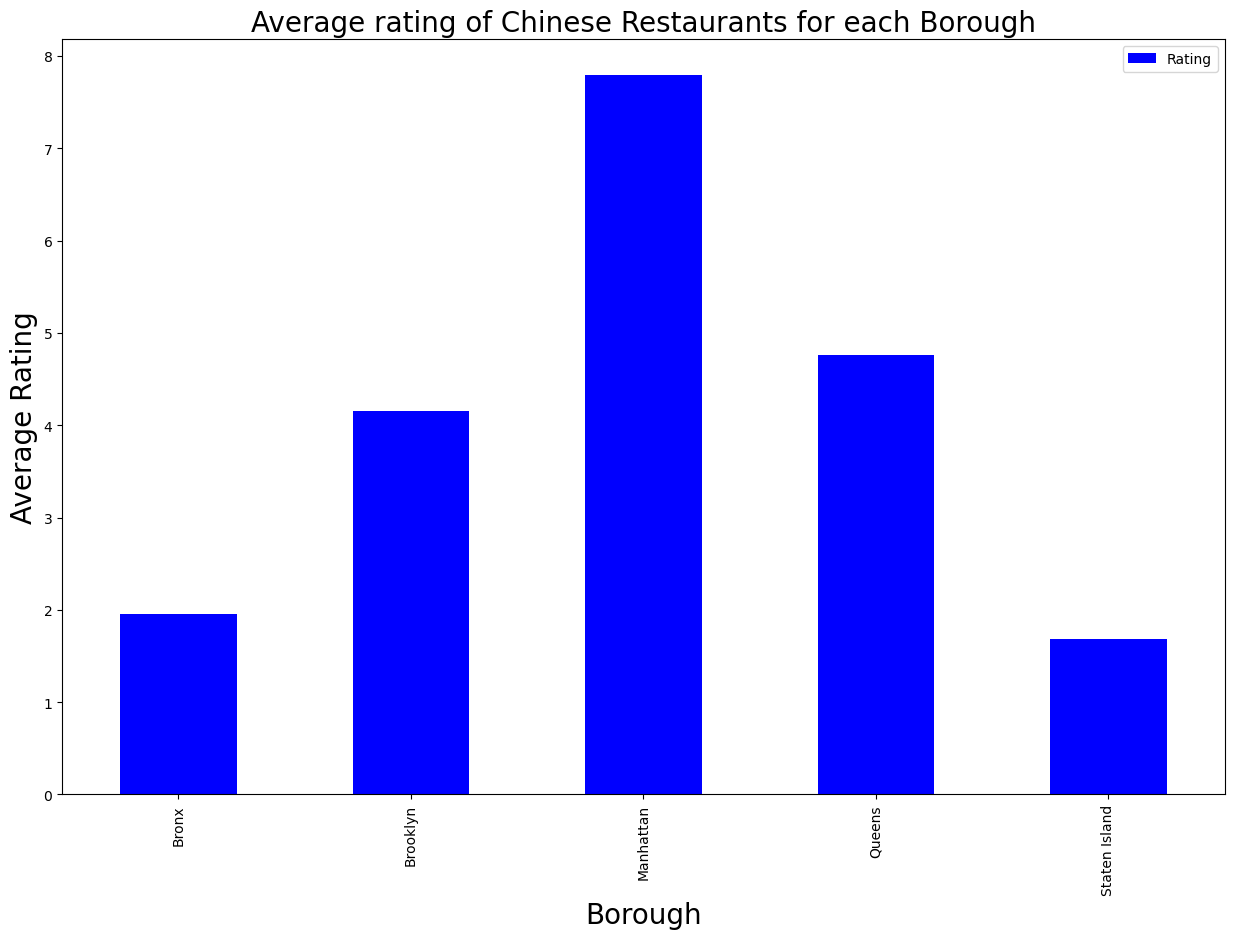

In [74]:
plt.figure(figsize=(15,10), dpi = 100)
plt.title('Average rating of Chinese Restaurants for each Borough', fontsize= 20, loc = 'center' )
plt.xlabel('Borough', fontsize = 20)
plt.ylabel('Average Rating', fontsize=20)
chinese_rest_stats.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

In [94]:
neighborhood_stats=neighborhood_stats[neighborhood_stats['Average Rating']>=8.2]
neighborhood_stats

,Neighborhood,Average Rating
16,Chelsea,8.800000
17,Chinatown,8.344444
29,Downtown,8.333333
33,East Village,8.300000
35,Elmhurst,8.200000
47,Greenwich Village,8.400000
59,Little Italy,8.200000
62,Lower East Side,8.350000
67,Midtown South,8.700000
69,Murray Hill,8.700000


For our map we will use only restaurants with rating higher than 8.2.

In [95]:
neighborhood_stats = pd.merge(neighborhood_stats,ny_data, on='Neighborhood')
neighborhood_stats

,Neighborhood,Average Rating,Borough,Latitude,Longitude
0,Chelsea,8.800000,Manhattan,40.744035,-74.003116
1,Chelsea,8.800000,Staten Island,40.594726,-74.189560
2,Chinatown,8.344444,Manhattan,40.715618,-73.994279
3,Downtown,8.333333,Brooklyn,40.690844,-73.983463
4,East Village,8.300000,Manhattan,40.727847,-73.982226
5,Elmhurst,8.200000,Queens,40.744049,-73.881656
6,Greenwich Village,8.400000,Manhattan,40.726933,-73.999914
7,Little Italy,8.200000,Manhattan,40.719324,-73.997305
8,Lower East Side,8.350000,Manhattan,40.717807,-73.980890
9,Midtown South,8.700000,Manhattan,40.748510,-73.988713


In [96]:
neighborhood_stats = neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [97]:
neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Chelsea,40.744035,-74.003116,8.800000
1,Staten Island,Chelsea,40.594726,-74.189560,8.800000
2,Manhattan,Chinatown,40.715618,-73.994279,8.344444
3,Brooklyn,Downtown,40.690844,-73.983463,8.333333
4,Manhattan,East Village,40.727847,-73.982226,8.300000
5,Queens,Elmhurst,40.744049,-73.881656,8.200000
6,Manhattan,Greenwich Village,40.726933,-73.999914,8.400000
7,Manhattan,Little Italy,40.719324,-73.997305,8.200000
8,Manhattan,Lower East Side,40.717807,-73.980890,8.350000
9,Manhattan,Midtown South,40.748510,-73.988713,8.700000


In [99]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='green',
            fill=True,
            fill_color='white',
            fill_opacity=0.4
        )
    )

In [100]:
ny_map

In [102]:
neighborhood_stats['Label'] = neighborhood_stats['Neighborhood']+', '+neighborhood_stats['Borough']+'('+neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup = label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)
ny_map

<ipython-input-102-4741ed15727d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighborhood_stats['Label'] = neighborhood_stats['Neighborhood']+', '+neighborhood_stats['Borough']+'('+neighborhood_stats['Average Rating'].map(str)+')'
